In [125]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Handling Data Quality Issues

In [126]:
# read data
df1 = pd.read_csv("glass_furnace_data.csv")

# columnize the data (every entry is stored in a single string instead of a table)
np_df1 = np.array(df1)
i = 0
arr = []
for row in np_df1:
    a = str(row[0]).split(",")
    if '' not in a:
        arr.append(a)
cols = (str(df1.columns).split(","))[:-1]

# update column names that can cause any confusion
new_df = pd.DataFrame(arr, columns = cols)
new_df.rename(columns={new_df.columns[0]: 'event_timestamp'}, inplace = True)
new_df.rename(columns={new_df.columns[-1]: 'BOOST_Z5'}, inplace = True)
d = {"BUBLER_TOT": ["TOTAL_BUBLER_TOT", "1st_BUBLER_TOT", "2nd_BUBLER_TOT"]}
new_df= new_df.rename(columns=lambda c: d[c].pop(0) if c in d.keys() else c)

# shift the target variable
new_df["TARGET"] = new_df["TEMP_0912"].shift(1)
new_df = new_df.drop(0)

In [127]:
# switch event_timestamp column's data type to datetime from string
new_df['event_timestamp'] = pd.to_datetime(new_df['event_timestamp'].str[:-4])

# sort df by ascending timestamp
df_sorted = new_df.sort_values(by='event_timestamp', ascending=True)

In [128]:
# drop unnecessary columns 
cols_to_be_dropped = []
lst = ["BUBLER_32", "BUBLER_16", "_1LI", "_1PI", "_1SIC", "TEMP_20", "_SET"]
for l in lst:
    cols_to_be_dropped.extend(list(df_sorted.filter(like=l, axis = 1).columns))
cleaned_df = df_sorted.drop(cols_to_be_dropped, axis = 1)

# numerize the datafame
for col in cleaned_df.columns:
    if col != "event_timestamp":
        cleaned_df[col] = pd.to_numeric(cleaned_df[col])

### Feature Generation

In [129]:
# create new columns from the ratio of gas and oxygen columns
for col in cleaned_df.columns:
    if "GAS" in col and col[-1] in ["L", "R"]:
        tmp = col[3:]
        cleaned_df[f"{col}/OKS{tmp}"] = cleaned_df[col]/cleaned_df[f"OKS{tmp}"]

### Exploratory Data Analysis

In [130]:
col_count_1 = len(cleaned_df.columns)
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34571 entries, 1 to 34571
Columns: 119 entries, event_timestamp to GAS_1007R/OKS_1007R
dtypes: datetime64[ns](1), float64(118)
memory usage: 31.4 MB


#### Correleation Matrix

In [131]:
cor_matrix = cleaned_df.drop(["event_timestamp"], axis = 1).corr().abs()
cors = dict(cor_matrix["TARGET"])
cols_2_be_dropped_2 = []
for key in cors:
    if not (cors[key] <= 1 and cors[key] >= -1): # if nan
        cols_2_be_dropped_2.append(key)  ### drop where the columns are constant
cleaned_df = cleaned_df.drop(cols_2_be_dropped_2, axis = 1)

In [132]:
# take 5 columns most correlated to target
def top5_corr(threshold):
    cors = dict(cleaned_df.drop(["event_timestamp"], axis=1).corr().abs()["TARGET"])
    cors = sorted(cors.items(), key=lambda x:x[1])
    cors.pop(-1)
    i = 0
    c = cors.pop(-1)
    top5 = []
    
    while(c[1]>threshold and i < 5):
        top5.append(c)
        c = cors.pop(-1)
        i+=1
    
    return top5

In [133]:
# take 5 columns most correlated to target
target_cor_cols = list(np.array(top5_corr(.5)).T[0])
target_cor_cols_vals = list(np.array(top5_corr(.5)).T[1])
target_cor_df = pd.DataFrame({"Column Name":target_cor_cols, "Correlation to Target": target_cor_cols_vals})
target_cor_df['Correlation to Target'] = pd.to_numeric(target_cor_df['Correlation to Target'])
target_cor_df['Correlation to Target'] = target_cor_df['Correlation to Target'].map('{:.3f}'.format)
target_cor_df = target_cor_df.style.set_caption("Top 5 Features Most Correlated to Target")
target_cor_df

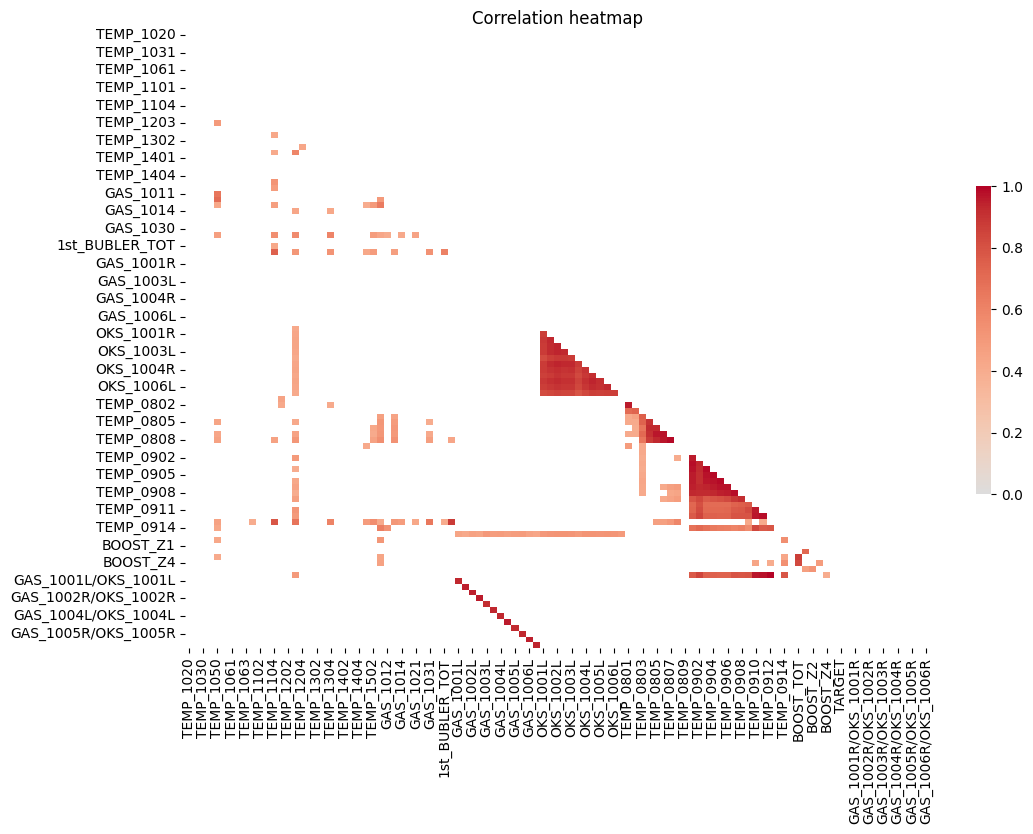

In [134]:
corr = cleaned_df.drop(["event_timestamp"], axis = 1).corr().abs()
corr[corr.abs() < 0.4] = np.nan

plt.figure(figsize=(12, 8))
sns.heatmap(corr.abs(), cmap="coolwarm", 
            mask=np.triu(np.ones_like(corr.abs(), dtype=bool)),
            cbar_kws={"shrink": .5}, vmin=0, vmax=1, center= 0)
plt.title('Correlation heatmap')
plt.show()

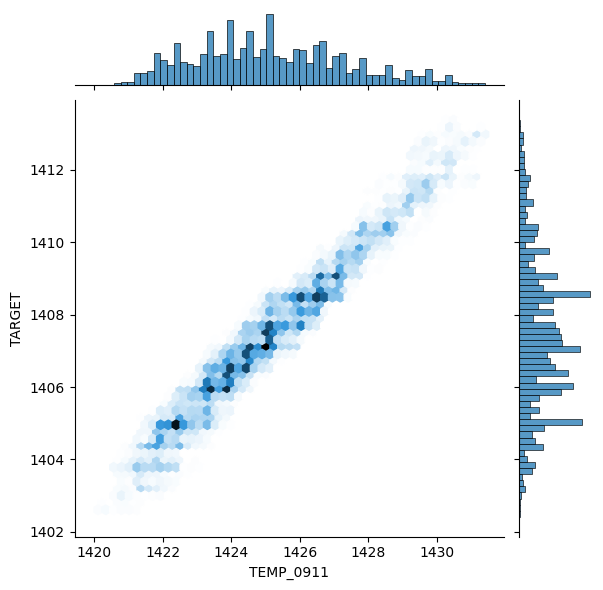

In [135]:
sns.jointplot(x='TEMP_0911', y='TARGET', data=cleaned_df, kind='hex')
plt.show()

In [136]:
# plot the distribution of Gas/Oxygen columns
def gas_o2_plots(col_name):
    y = np.array(cleaned_df[col_name])
    x = enumerate(y)
    tmp = list(x)
    x = list(np.array(tmp).T[0])
    
    plt.hist(np.array(cleaned_df[col_name]),range=[y.mean()-y.std()*2, y.mean()+y.std()*2])
    plt.title(f"{col_name} distribution")
    plt.grid(axis = 'y')
    plt.show()
    
    plt.scatter(x,y)
    plt.ylim([y.mean()-y.std()*2, y.mean()+y.std()*2])
    plt.xlim([0, 75])
    plt.title("Scatter plot with 75 samples")
    plt.axhline(y=y.mean(), color='r', linestyle='--', label='Mean')
    plt.show()
    
    plt.scatter(x,y)
    plt.ylim([y.mean()-y.std()*2, y.mean()+y.std()*2])
    plt.xlim([0, 1000])
    plt.title("Scatter plot with 1000 samples")
    plt.axhline(y=y.mean(), color='r', linestyle='--', label='Mean')
    plt.show()
    
    plt.boxplot(y)
    plt.ylim([y.mean()-y.std()*2, y.mean()+y.std()*2])
    plt.show()
    print(f"mean: {y.mean():.5f}")
    print(f"std: {y.std():.5f}")
    print(f"min: {y.min():.5f}")
    print(f"max: {y.max():.5f}")
    print(f"q1: {cleaned_df[col_name].quantile(0.25):.5f}")
    print(f"q3: {cleaned_df[col_name].quantile(0.75):.5f}")
    print("\n")
    
    return [col_name, y.mean(), y.std(), y.min(), y.max()]

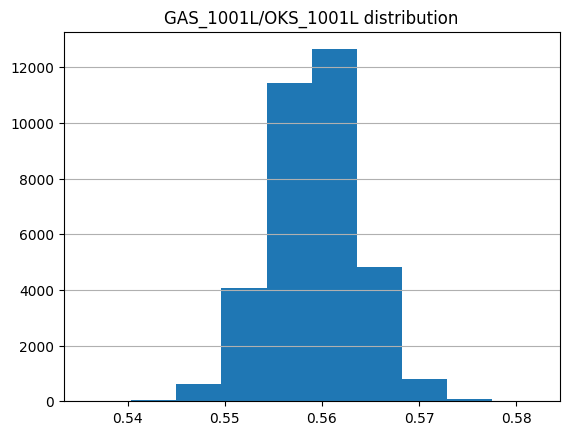

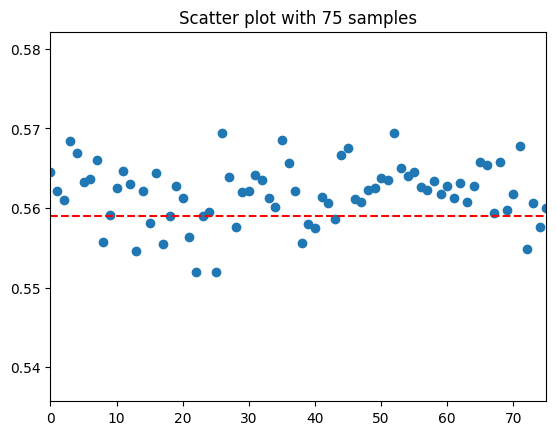

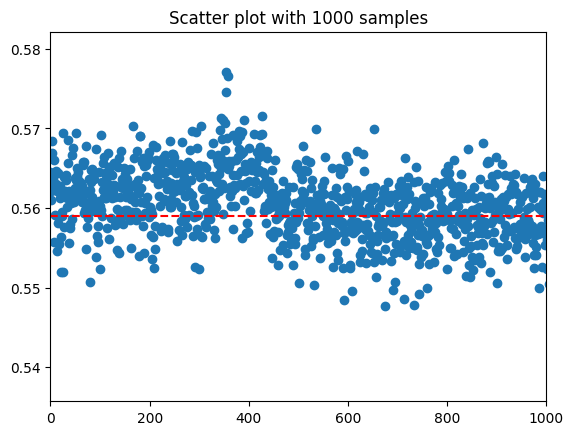

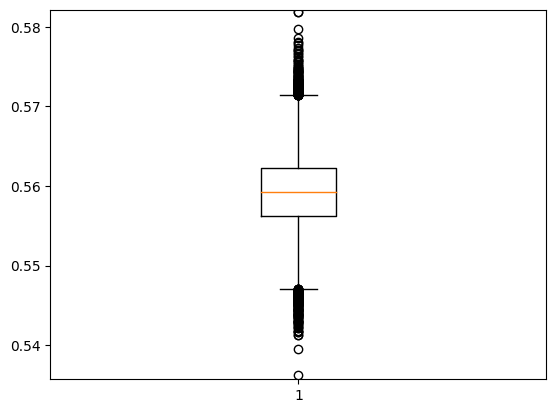

mean: 0.55893
std: 0.01161
min: 0.04600
max: 0.58191
q1: 0.55619
q3: 0.56227




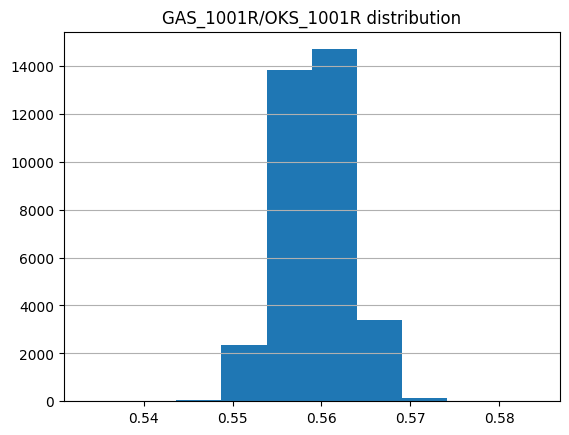

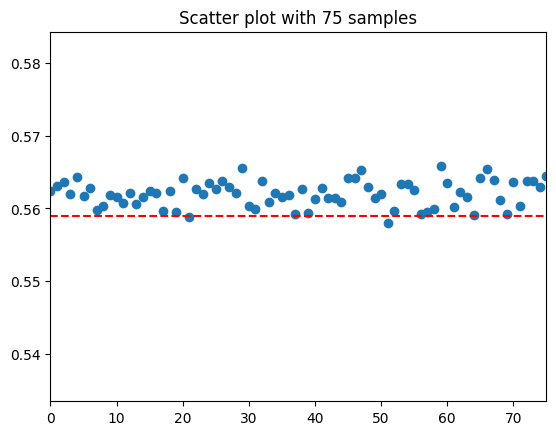

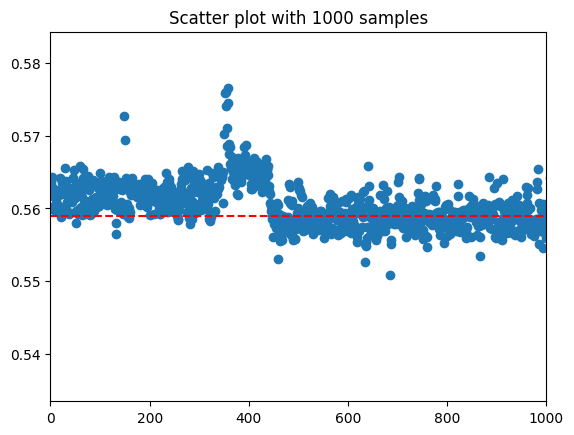

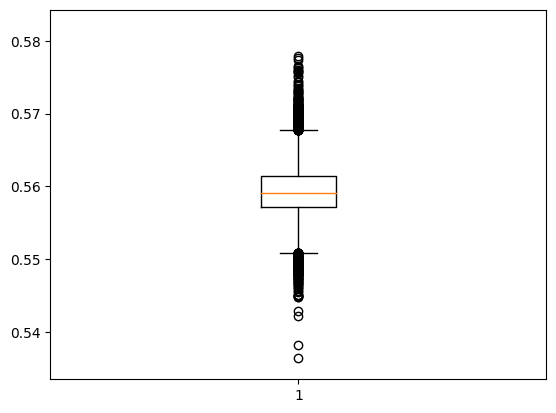

mean: 0.55890
std: 0.01269
min: -0.00000
max: 0.57795
q1: 0.55719
q3: 0.56140




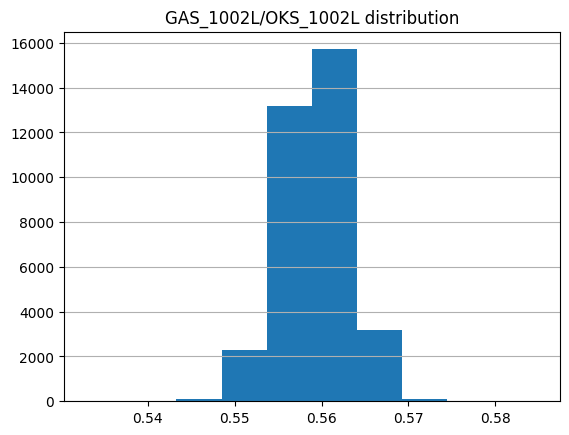

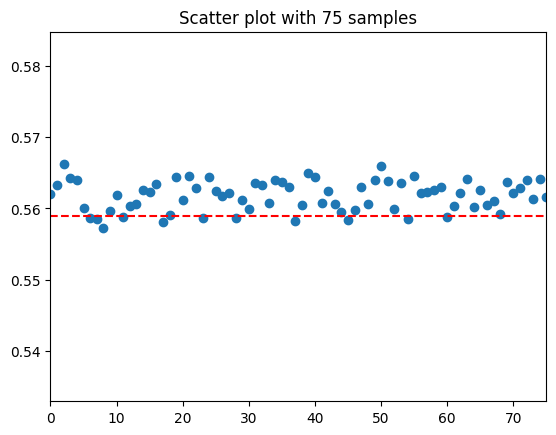

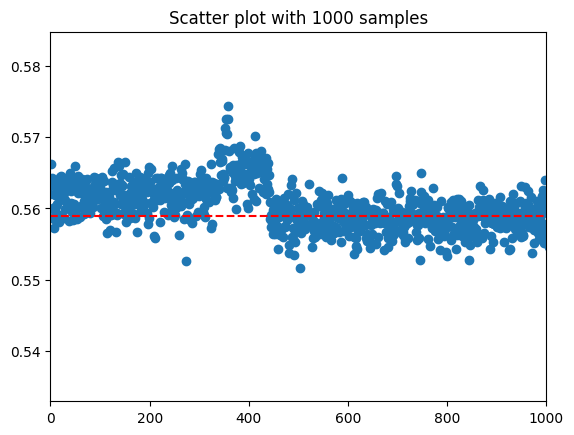

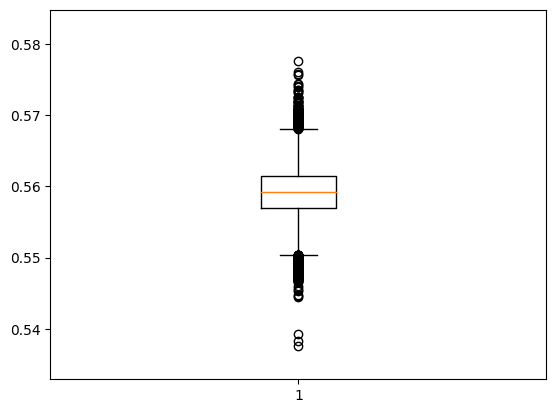

mean: 0.55887
std: 0.01298
min: 0.02680
max: 0.57757
q1: 0.55702
q3: 0.56146




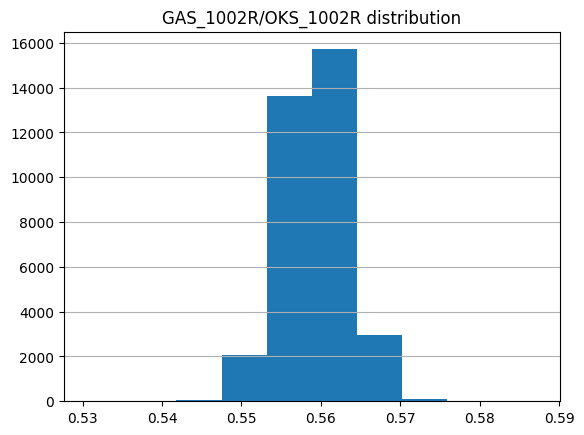

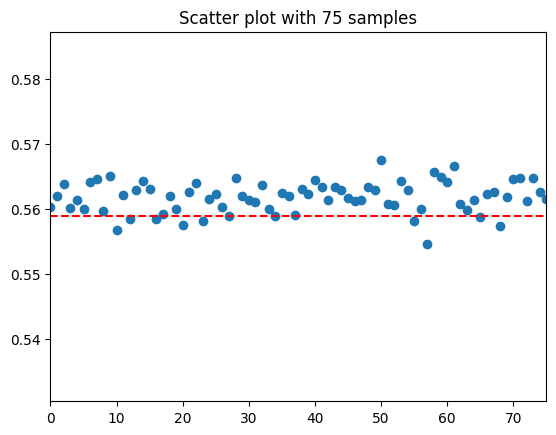

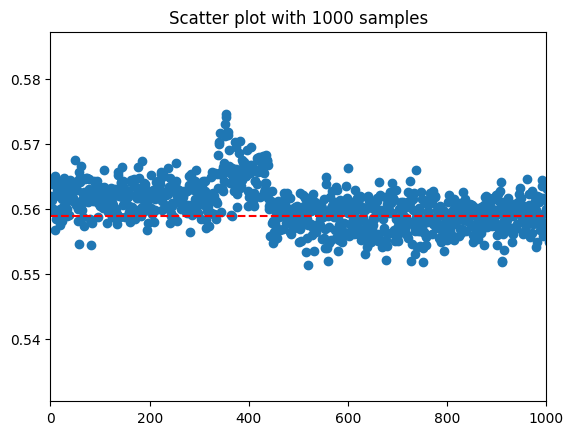

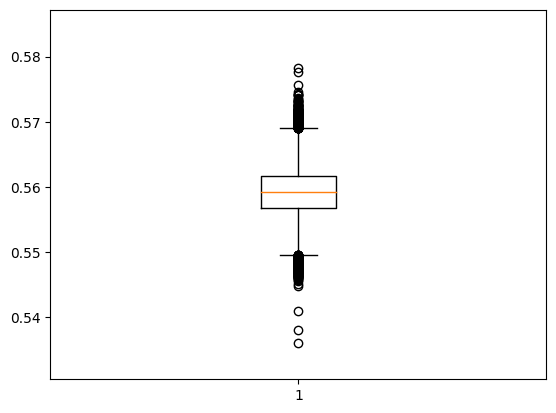

mean: 0.55884
std: 0.01418
min: -0.00000
max: 0.57830
q1: 0.55682
q3: 0.56171




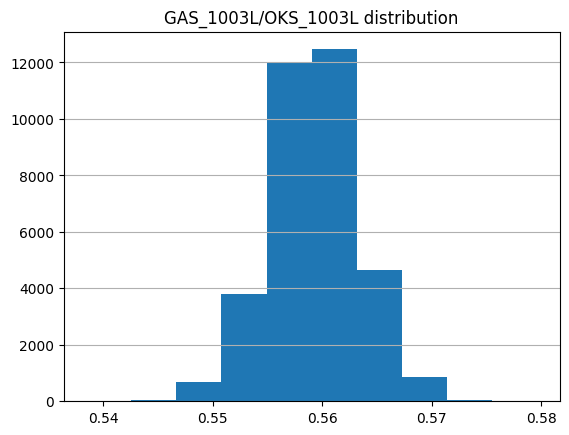

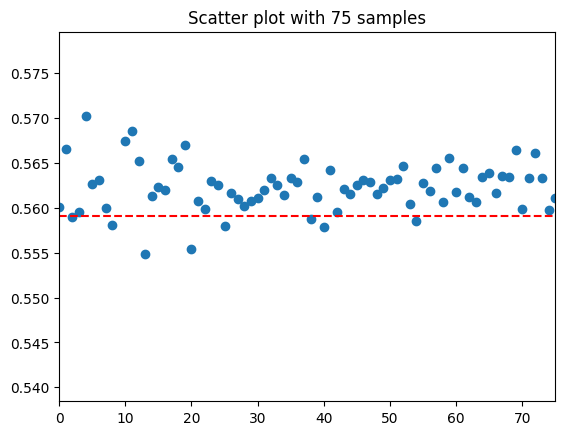

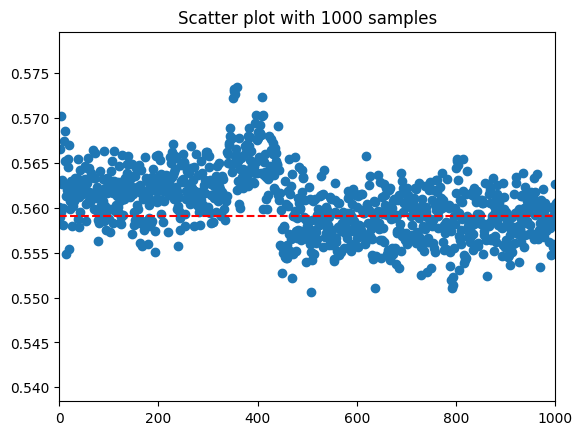

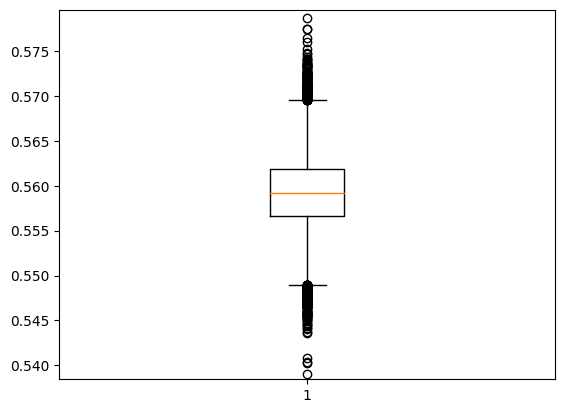

mean: 0.55903
std: 0.01030
min: 0.02442
max: 0.61695
q1: 0.55669
q3: 0.56184




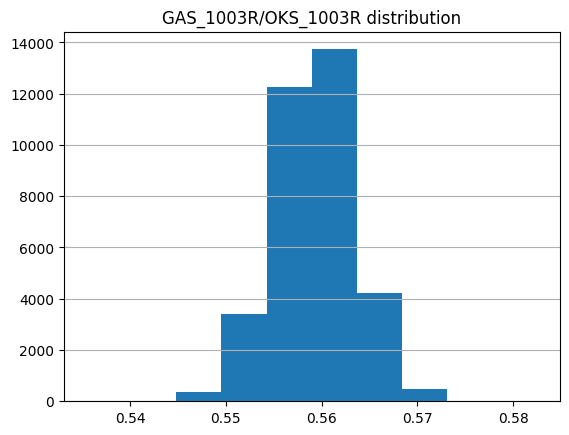

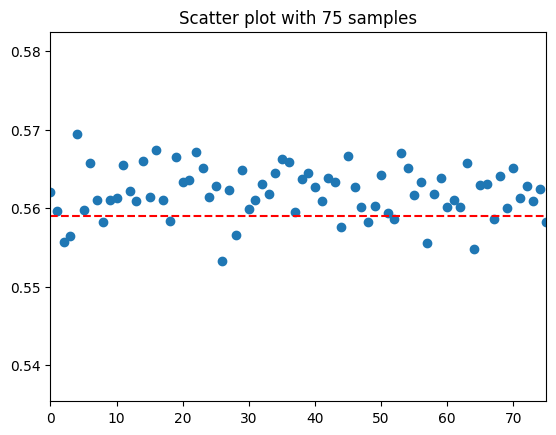

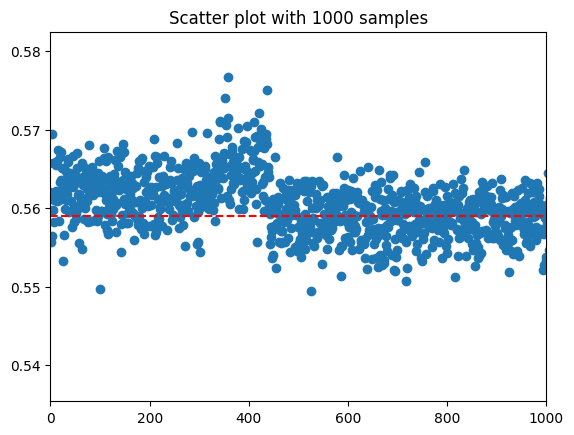

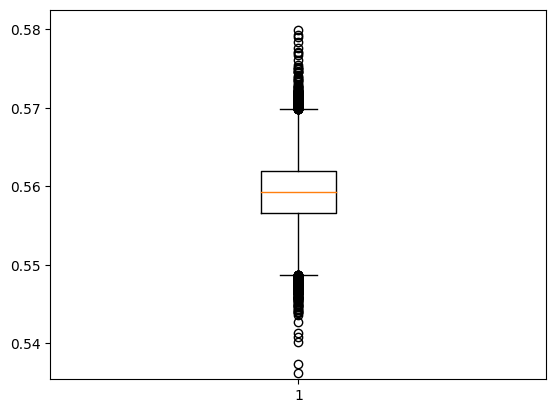

mean: 0.55895
std: 0.01177
min: 0.02277
max: 0.57987
q1: 0.55661
q3: 0.56190




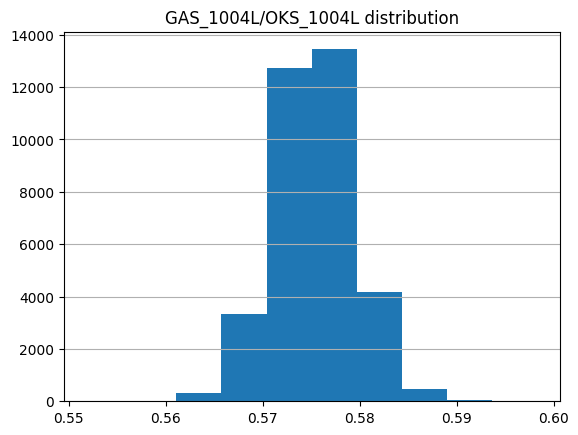

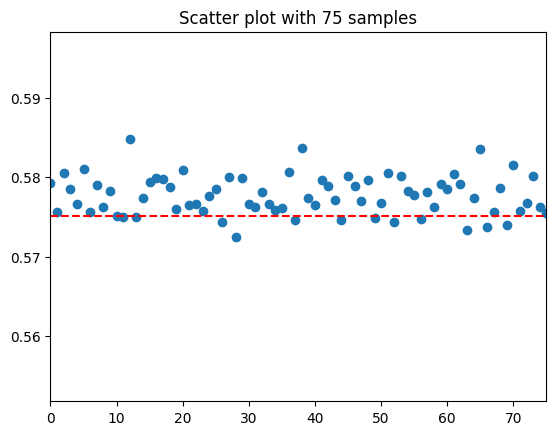

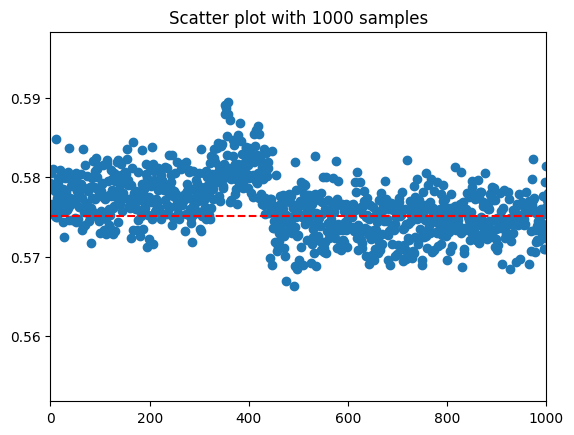

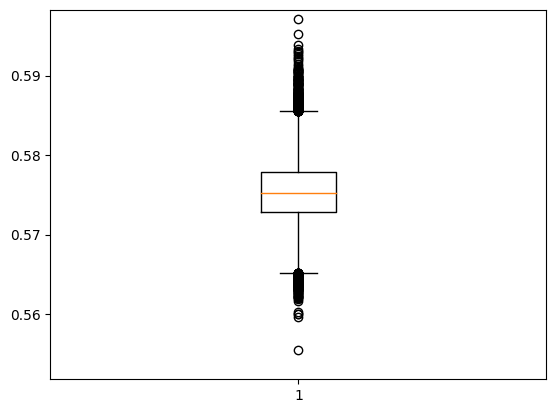

mean: 0.57505
std: 0.01162
min: -0.00000
max: 0.60009
q1: 0.57280
q3: 0.57788




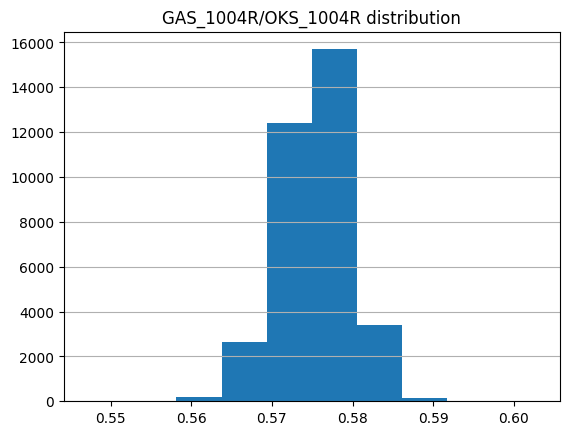

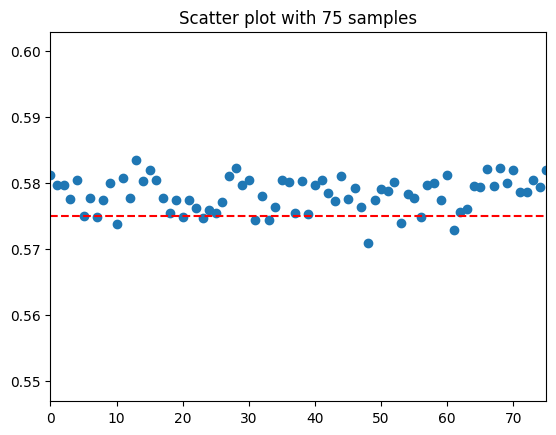

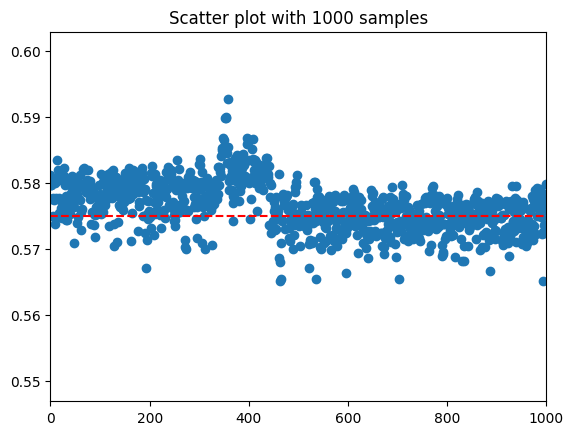

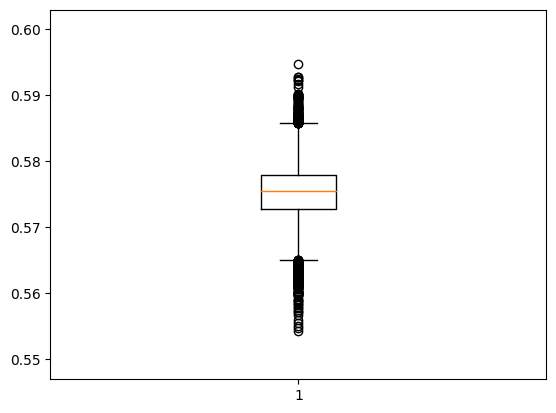

mean: 0.57494
std: 0.01398
min: -0.00000
max: 0.59476
q1: 0.57274
q3: 0.57793




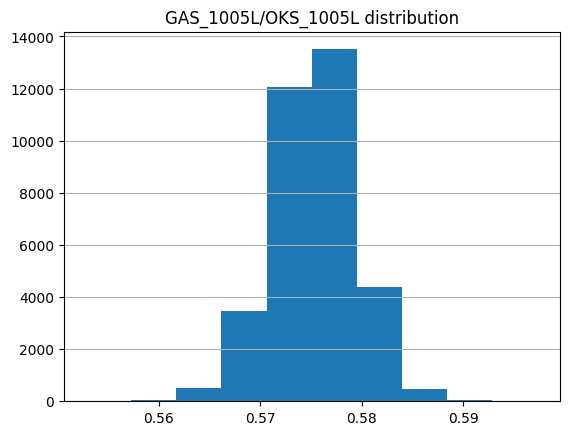

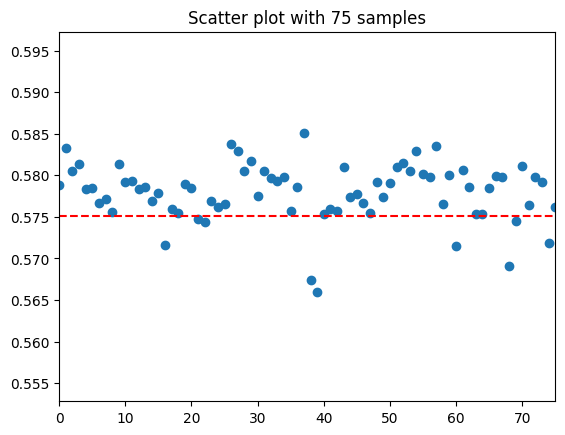

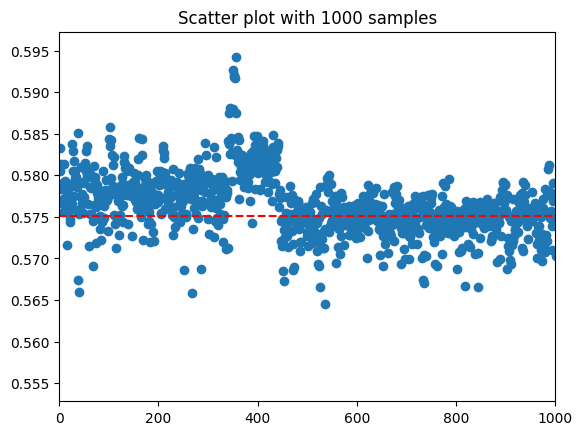

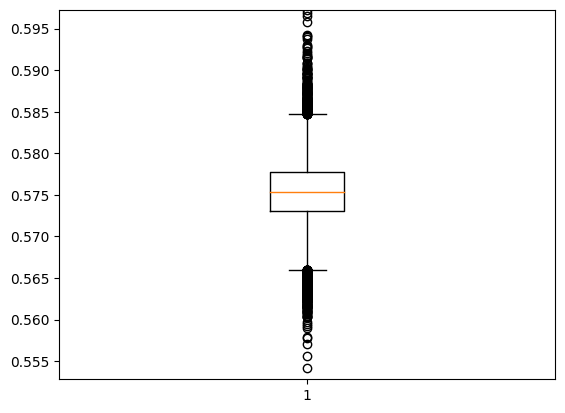

mean: 0.57505
std: 0.01111
min: 0.03183
max: 0.60047
q1: 0.57304
q3: 0.57773




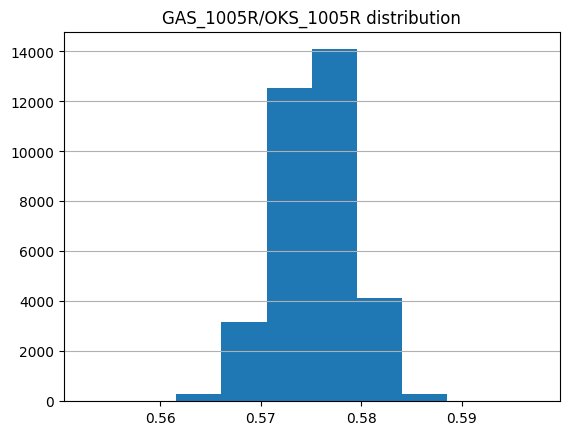

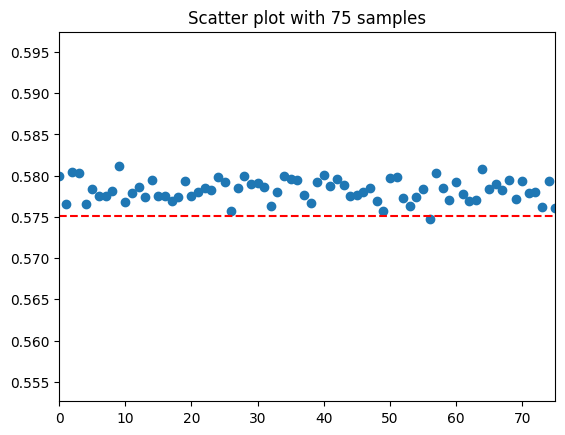

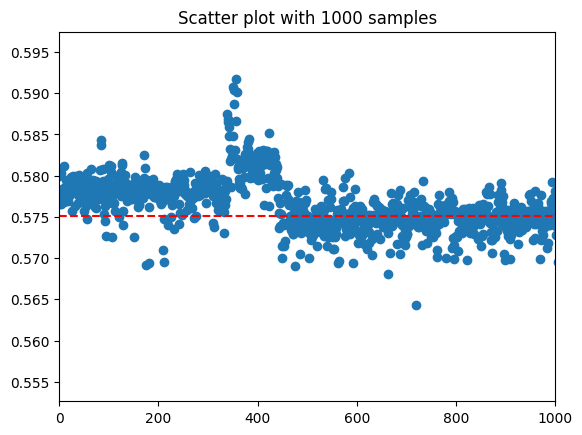

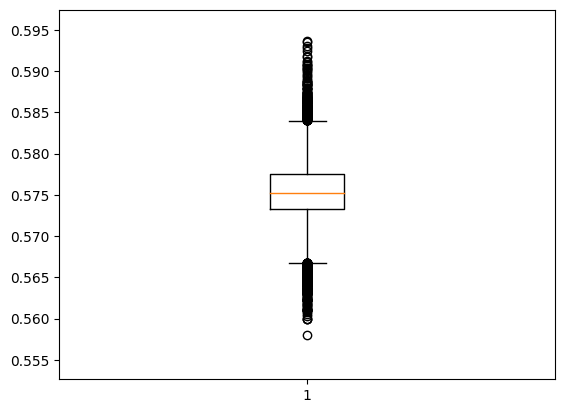

mean: 0.57505
std: 0.01121
min: 0.03083
max: 0.64995
q1: 0.57325
q3: 0.57756




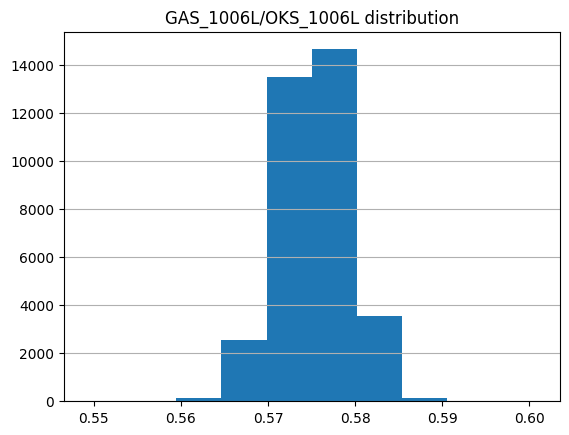

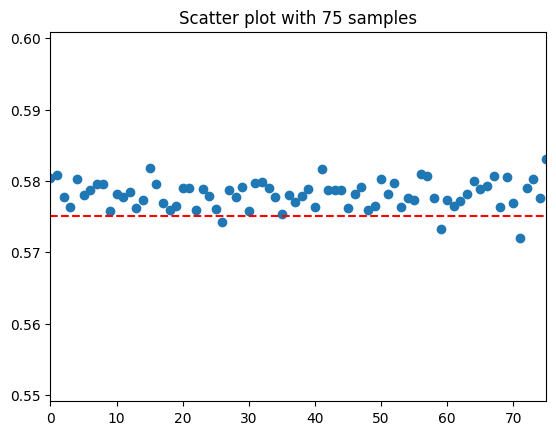

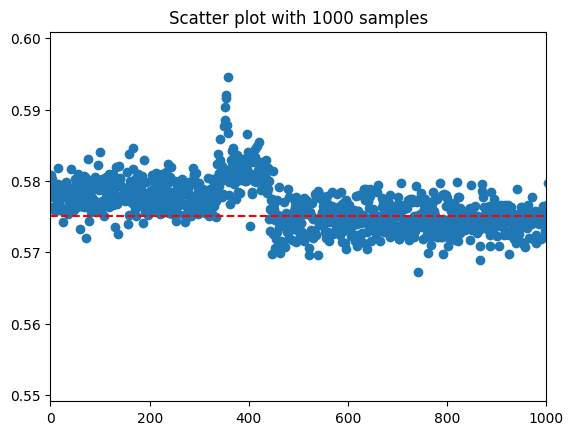

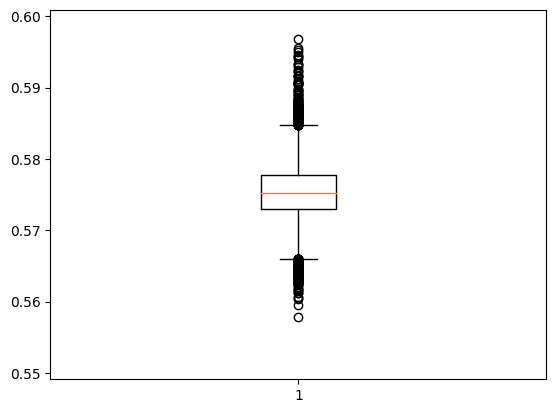

mean: 0.57501
std: 0.01295
min: -0.00000
max: 0.59681
q1: 0.57303
q3: 0.57773




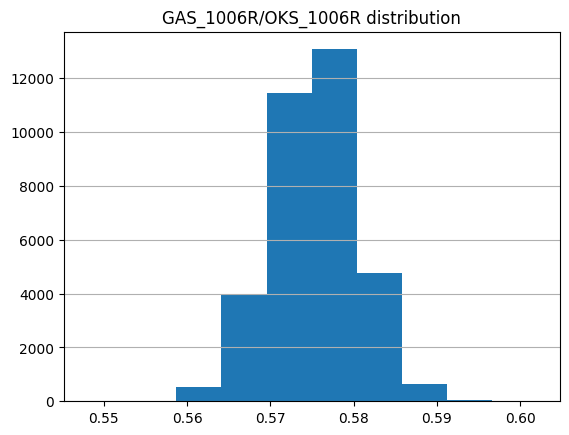

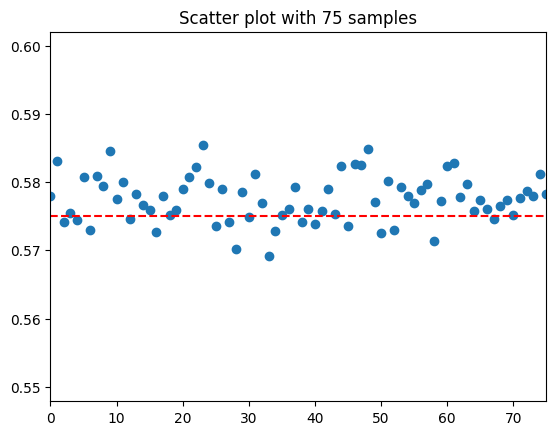

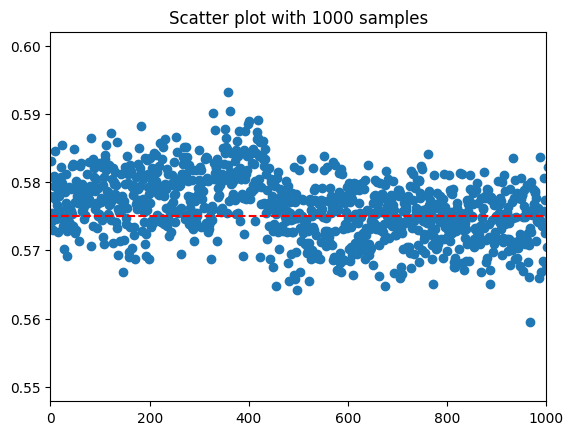

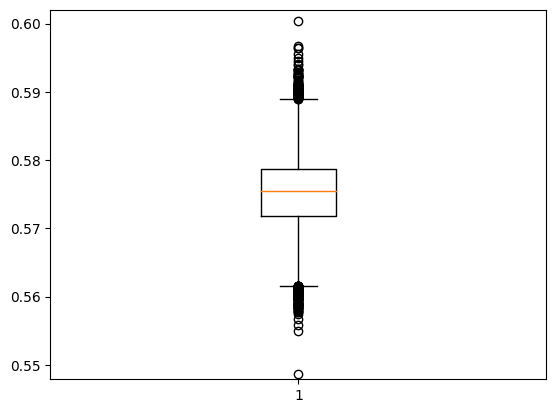

mean: 0.57495
std: 0.01354
min: -0.00000
max: 0.60037
q1: 0.57186
q3: 0.57872




In [137]:
cols = cleaned_df.filter(like="/OKS").columns
gas_o2_stats = []
for col in cols:
    stats = gas_o2_plots(col)
    gas_o2_stats.append(stats)

In [138]:
# store a df without temp_0912 for later use
w_out_912 = cleaned_df.drop(["TEMP_0912"], axis = 1) 

### Feature Selection

In [139]:
# a function to list features which are correlated to each other (more than a threshold)
# returns a list of lists. inner lists contains indexes of features which are all correlated

def find_correlated_features(threshold):
    i = 0
    highly_corr = []
    for r in np.array(all_cors):
        lst = list(r)
        for j in range(len(lst)):
            if lst[j] >= 0.5 and i<j:
                tup = (i, j)
                highly_corr.append(tup)
        i+=1

    dct = {}
    for t in highly_corr:
        if t[0] not in dct:
            if len(dct) == 0:
                dct[t[0]] = [t[0], t[1]]
            else:
                flag = True
                for key in dct:
                    if t[0] in dct[key]:
                        flag = False
                if flag:
                    dct[t[0]] = [t[0], t[1]]    
        else:
            dct[t[0]].append(t[1])


    return list(dct.values())

In [140]:
# takes an array which contains the indexes of correlated features (can be acquired via the function above)
# the feature which is most correlated to target gets separated from them
# returns the remaining features' list. they will be removed later
def remove_max_corr(arr, df):
    return_arr = []
    maximum = 0
    for index in arr:
        col = pd.DataFrame(df.iloc[:,index]).columns[0]
        if str(col) != "Target":
            return_arr.append(col)
        if cors_keys.index(col) > maximum:
            max_cor = col
    return_arr.pop(return_arr.index(col))
    
    return return_arr

In [141]:
"""
actually removes the correlated features. 
only the one which is correlated to target most stays for every correlated features list 
uses the 2 functions above
"""
def remove_highly_corr(threshold, df):
    highly_corr = find_correlated_features(.9)
    extracted = []
    for arr in highly_corr:
        ext = remove_max_corr(arr, df)
        for feature in ext:
            extracted.append(feature)
    
    df.drop(list(set(extracted)), axis = 1, inplace = True)

In [142]:
# updating the global parameters for function to use
cors_keys = list(cors.keys()) 
all_cors = cleaned_df.drop(["event_timestamp"], axis = 1).corr().abs()

# calling the function
remove_highly_corr(0.9, cleaned_df)
print(f"{col_count_1 - len(cleaned_df.columns)} out of {col_count_1} features are eliminated")

72 out of 119 features are eliminated


### Remove Outliers

In [144]:
# remove the entries which are outside of 1.5 IQR interval (outliers)
# only based on the target variable
def remove_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    df_out = df[~((df[column_name] < (Q1 - 1.5 * IQR)) | (df[column_name] > (Q3 + 1.5 * IQR)))]
    return df_out

outlierless_df = remove_outliers(cleaned_df, "TARGET")
print(f"{len(cleaned_df) - len(outlierless_df)} out of {len(cleaned_df)} entries are eliminated")

175 out of 34571 entries are eliminated


### Data Preprocessing

In [145]:
# normalize the data
normalized_df = (outlierless_df-outlierless_df.mean())/outlierless_df.std()

# split the data to train and test sets
# not randomly, the separation should be based on timestamp
# 1st 80% is train, other is test set
split_index = 4*len(normalized_df)//5
train_data = normalized_df.loc[:split_index]
test_data = normalized_df.loc[split_index+1:]

In [146]:
# separate the target variable from others
# also drop timestamp column
X_train = (np.array(train_data.drop(["TARGET", "event_timestamp"], axis = 1))).astype('float64')
y_train = (np.array(train_data["TARGET"]).astype('float64')).astype('float64')

X_test = (np.array(test_data.drop(["TARGET", "event_timestamp"], axis = 1))).astype('float64')
y_test = (np.array(test_data["TARGET"])).astype('float64')

In [147]:
# a function to visualize the results
# takes actual y values and prediction
# draws residual plots
def draw_results(y_test ,predictions, model_name):
    residuals = y_test - predictions

    # Create a figure and axes
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

    # Residual plot
    sns.scatterplot(x=predictions, y=residuals, ax=ax[0])
    ax[0].set_title(f'Residual Plot ({model_name})')
    ax[0].set_xlabel('Predicted Values')
    ax[0].set_ylabel('Residuals')
    ax[0].axhline(y=0, color='r', linestyle='--')

    # Prediction error plot
    sns.histplot(residuals, kde=True, ax=ax[1])
    ax[1].set_title(f'Prediction Error Plot ({model_name})')
    ax[1].set_xlabel('Residuals')

    plt.show()

In [148]:
from sklearn.preprocessing import normalize
def plot_feature_importance(threshold, model, model_name, df):
    if model_name == 'Linear Regression':
        importance = model.coef_
    elif model_name == 'LightGBM':
        importance = model.feature_importances_
    else:
        return
        
    importance = normalize([importance])[0]
    
    important_cols = list(df.columns)
    
    # Create arrays for features and their importance scores that pass the threshold
    important_features = np.array(important_cols)[np.abs(importance) > threshold]
    important_scores = importance[np.abs(importance) > threshold]

    # Create a sorted index for the scores
    sorted_index = np.argsort(important_scores)

    # Create labels
    labels = np.array(important_features)[sorted_index]

    # Create plot
    plt.figure(figsize=(10,6))
    plt.barh(range(len(sorted_index)), important_scores[sorted_index], tick_label=labels)
    if model_name == 'Linear Regression':
        plt.xlim(round(importance.min()-0.049,1), 1)
    elif model_name == 'LightGBM':
        plt.xlim(0, 1)
    plt.xlabel('Importance Score')
    plt.title(f'Feature Importances ({model_name})')
    plt.grid(axis='x')
    plt.show()

Linear Regression - MSE: 0.002, MAE: 0.029, R^2: 0.997


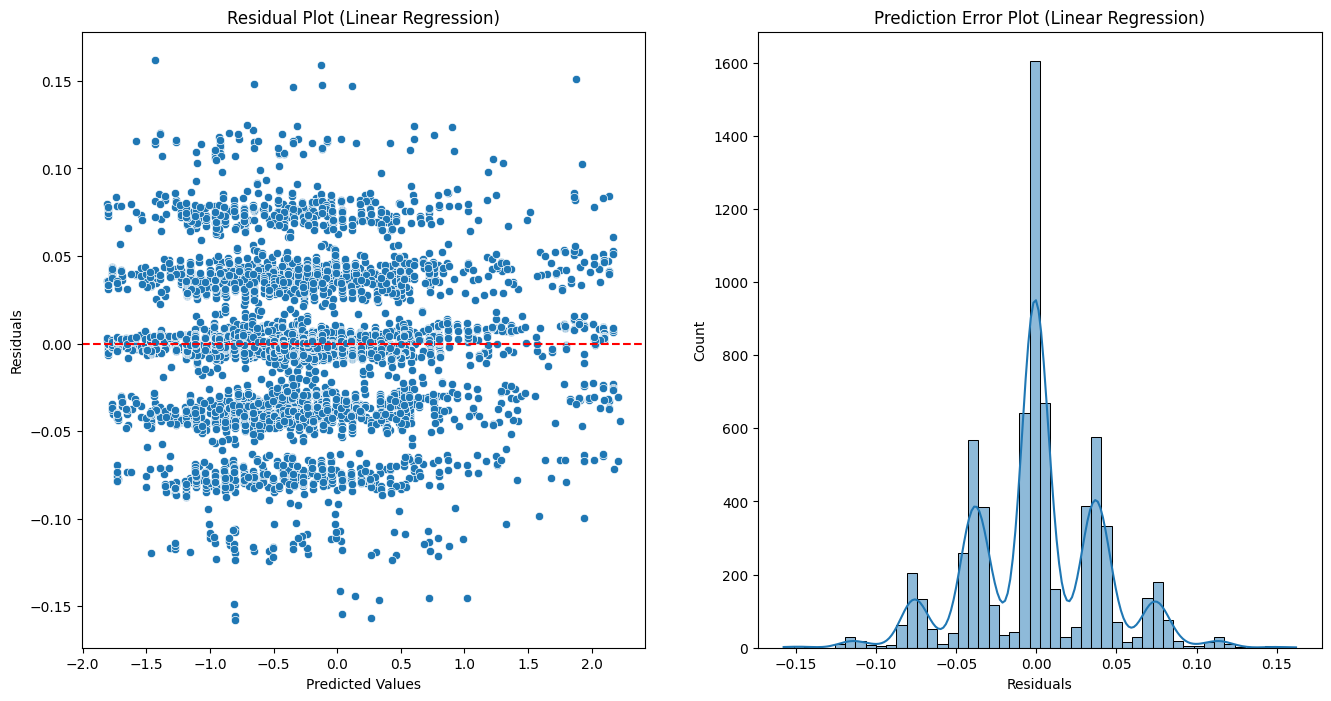

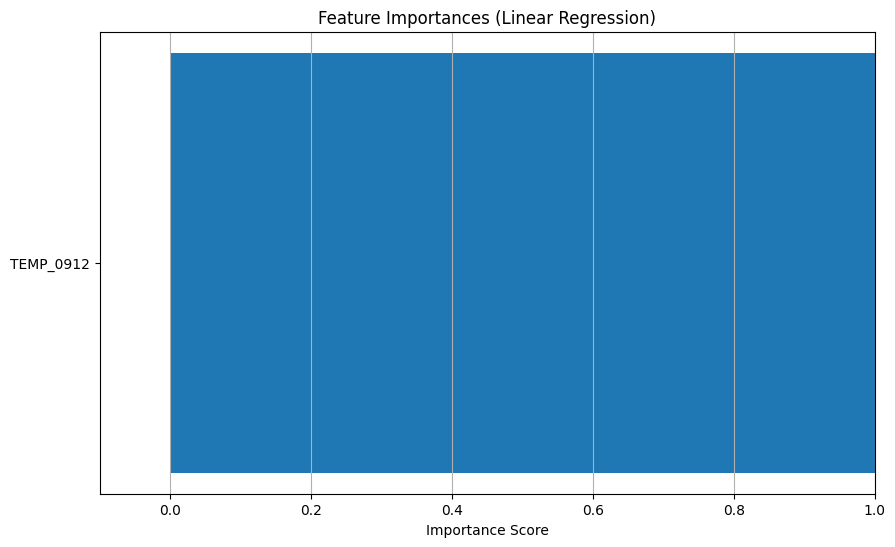

Polynomial Regression - MSE: 0.002, MAE: 0.033, R^2: 0.996


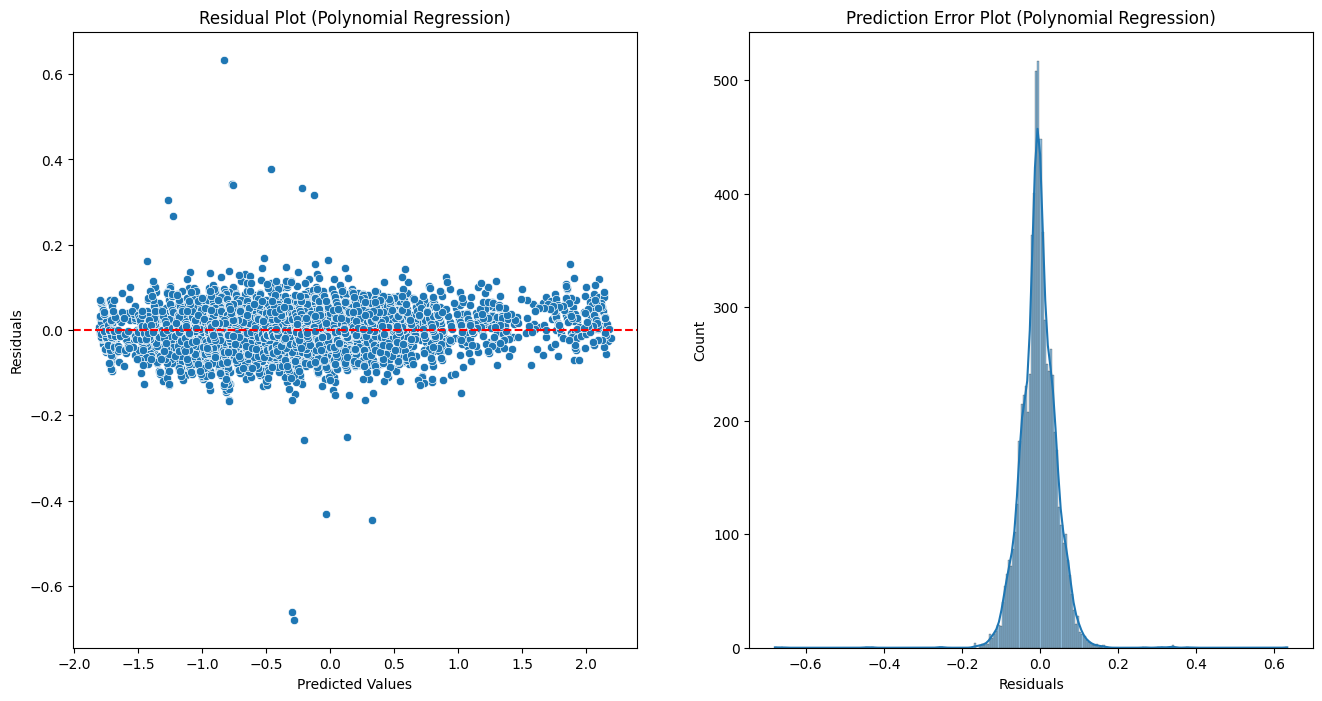

Ridge Regression - MSE: 0.002, MAE: 0.029, R^2: 0.997


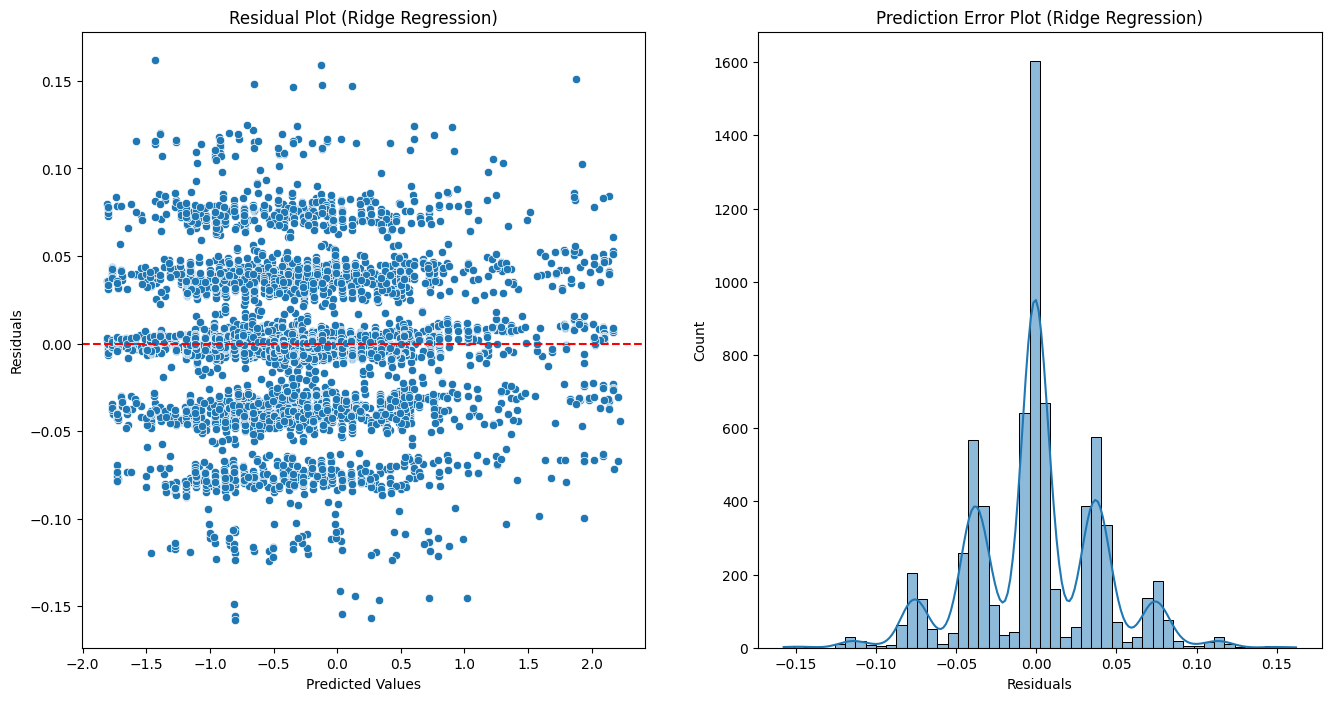

Lasso - MSE: 0.002, MAE: 0.031, R^2: 0.997


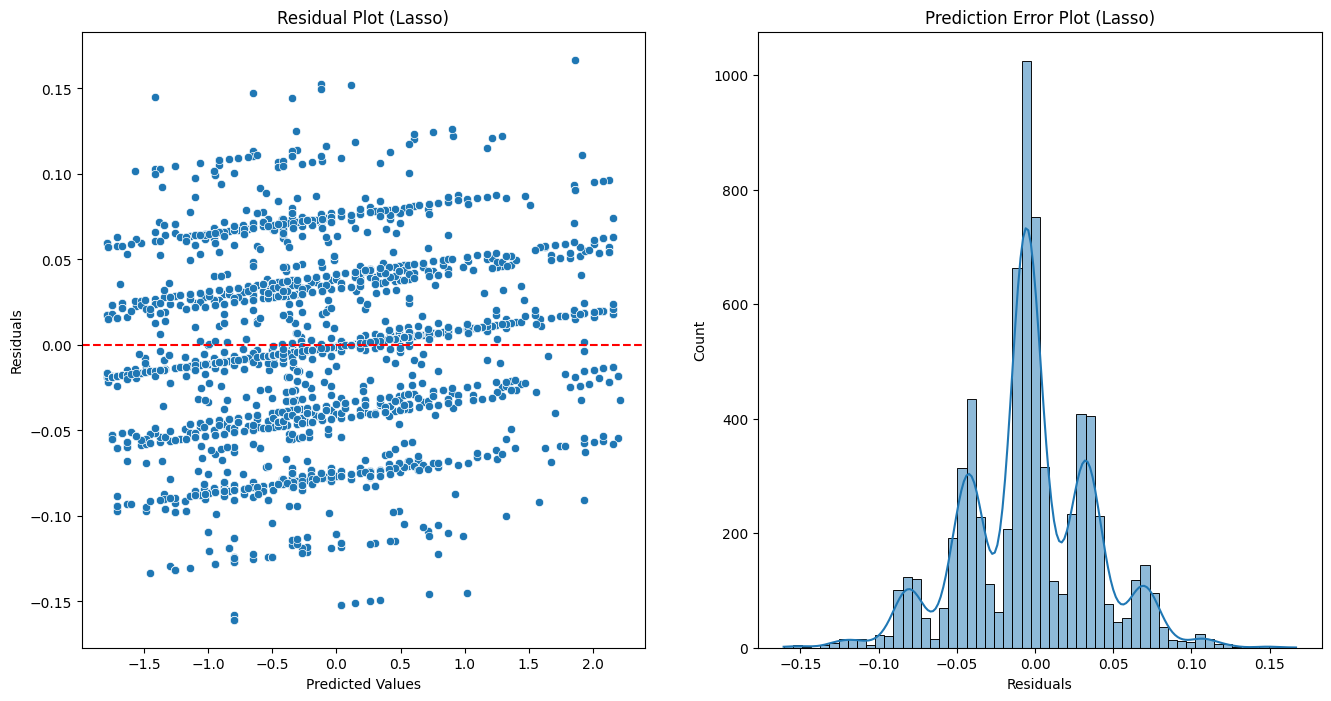

Decision Tree - MSE: 0.004, MAE: 0.049, R^2: 0.992


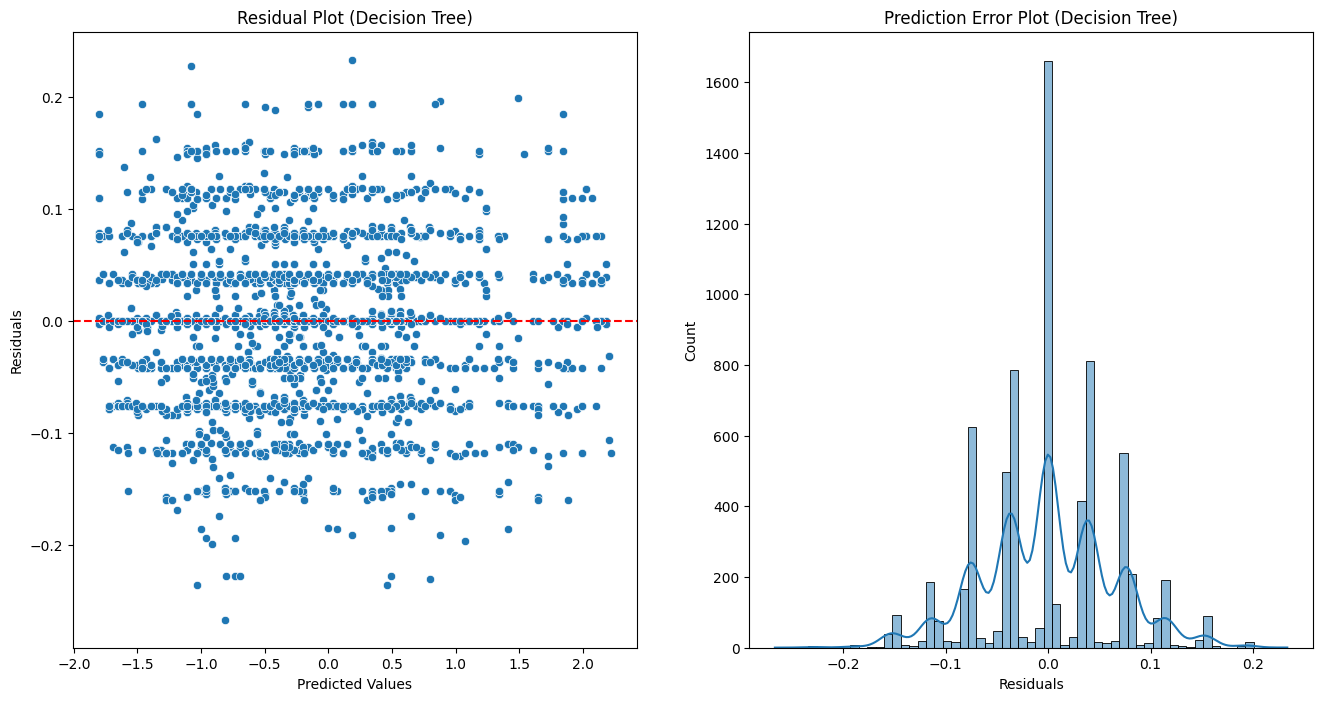

Gradient Boosting - MSE: 0.002, MAE: 0.031, R^2: 0.997


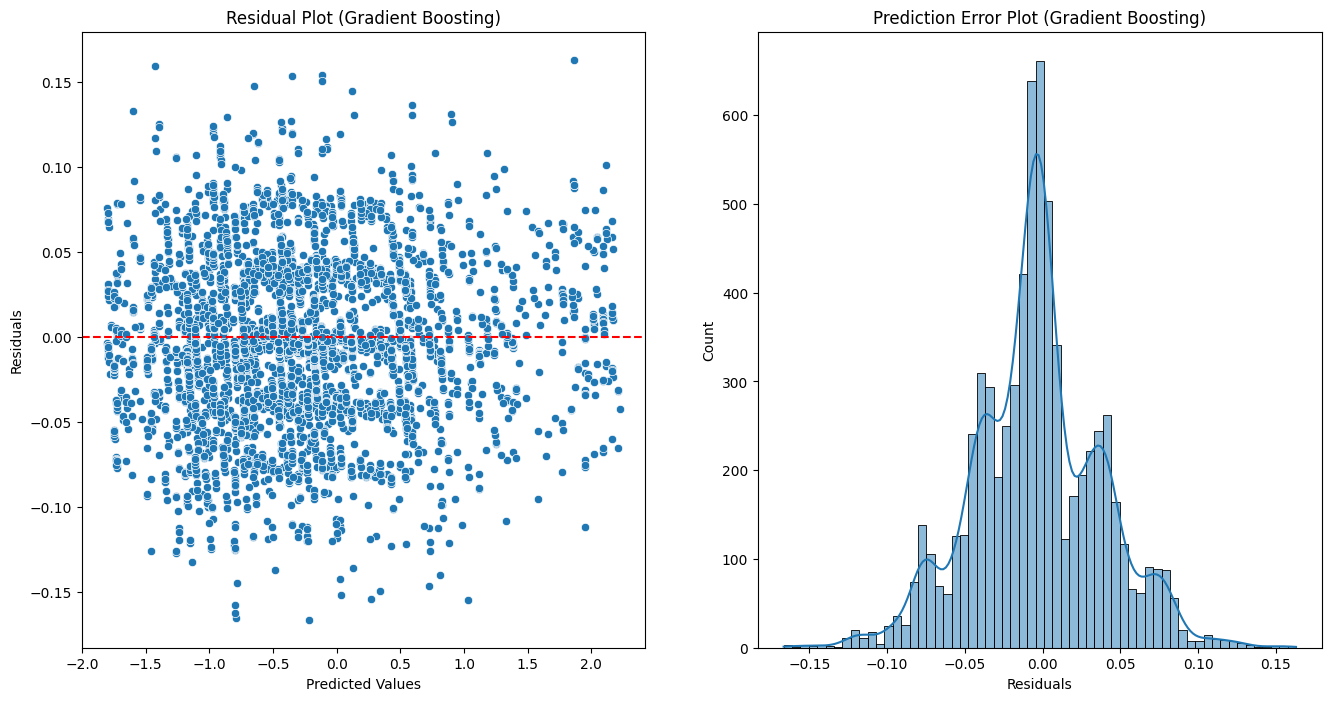

AdaBoost - MSE: 0.003, MAE: 0.045, R^2: 0.994


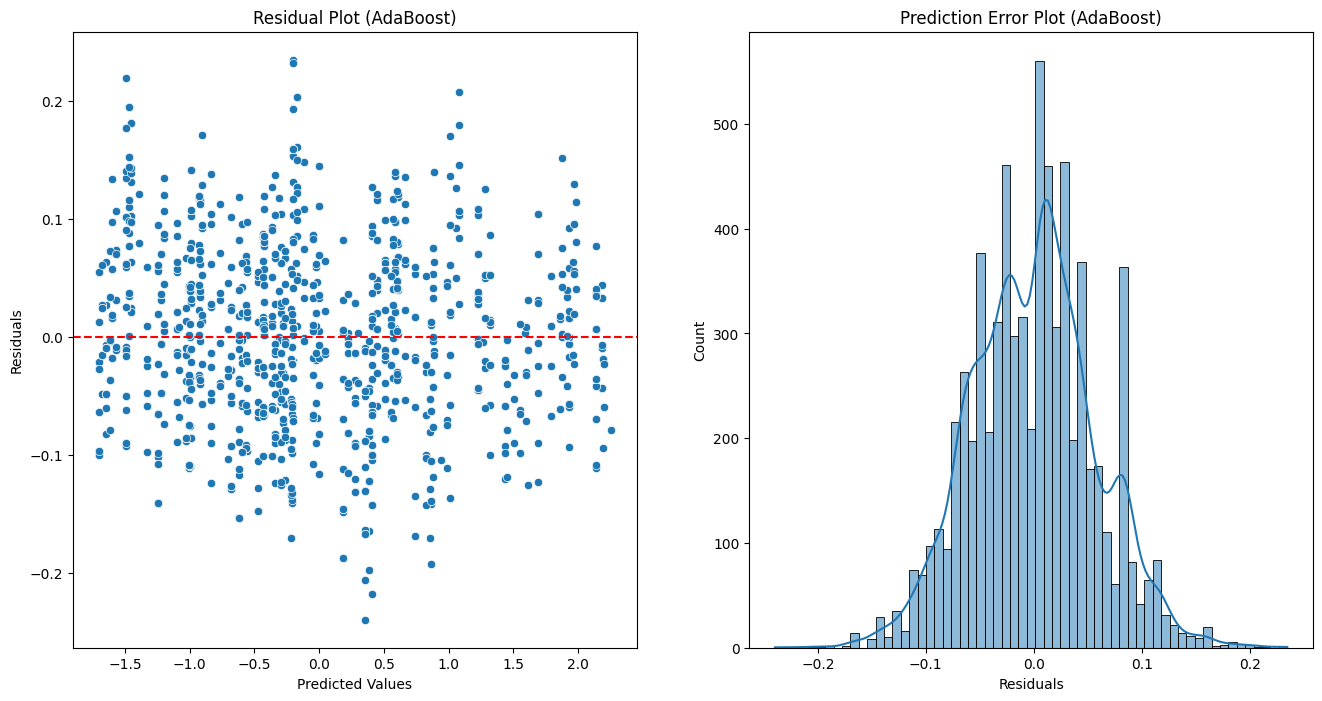

XGBoost - MSE: 0.002, MAE: 0.035, R^2: 0.996


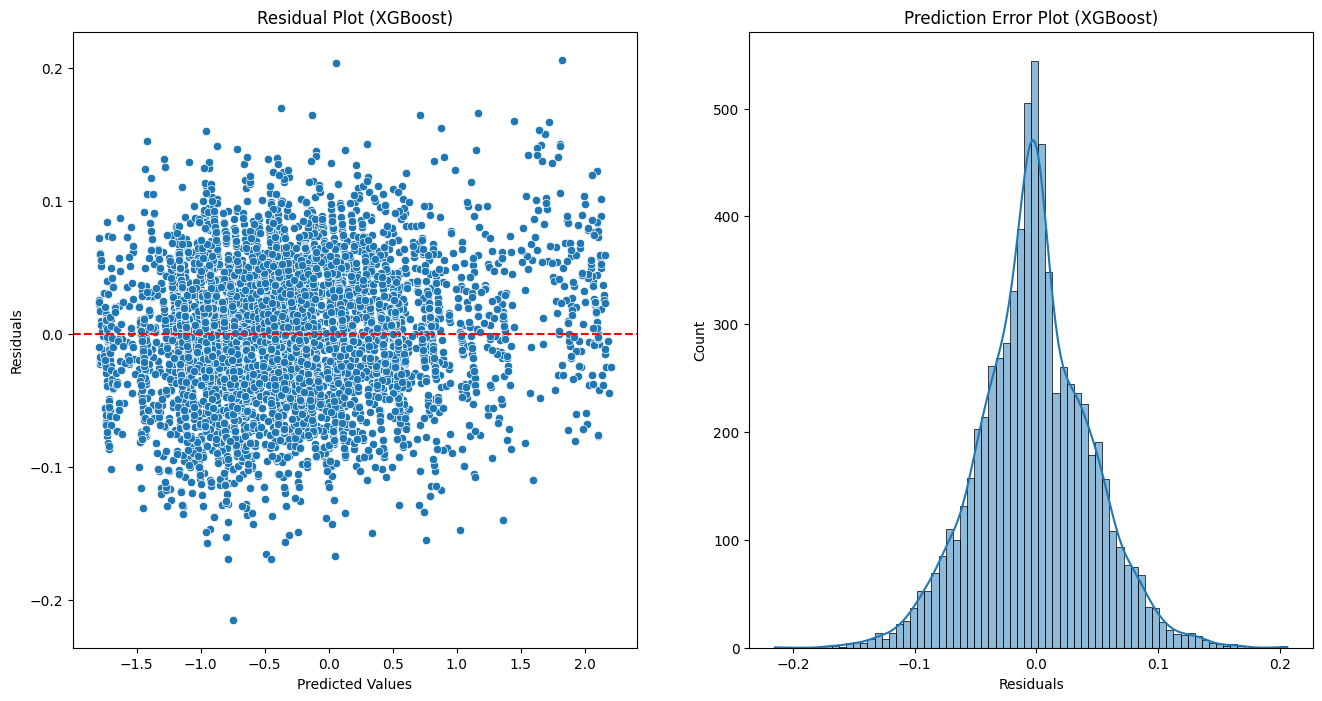

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005049 seconds.
You can set `force_col_wise=true` to remove the overhead.
LightGBM - MSE: 0.002, MAE: 0.031, R^2: 0.997


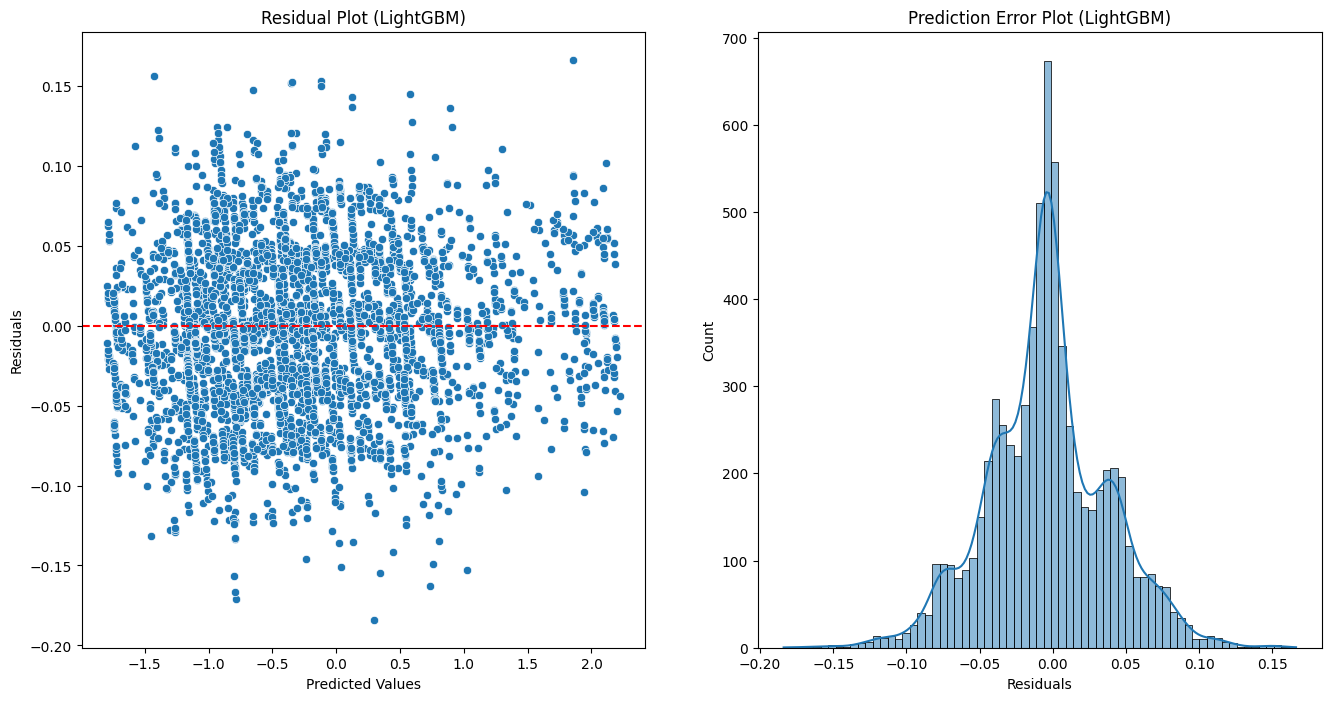

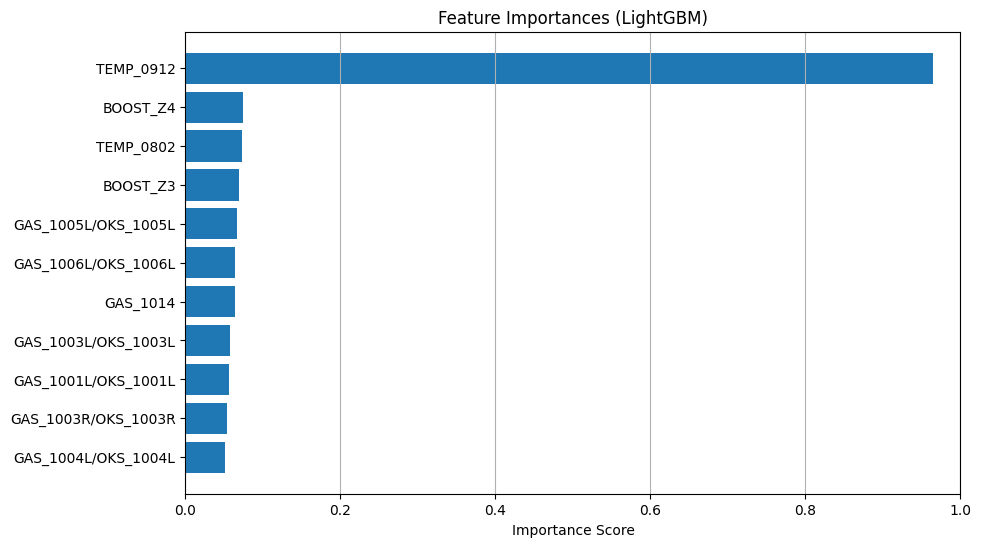

CatBoost - MSE: 0.002, MAE: 0.034, R^2: 0.996


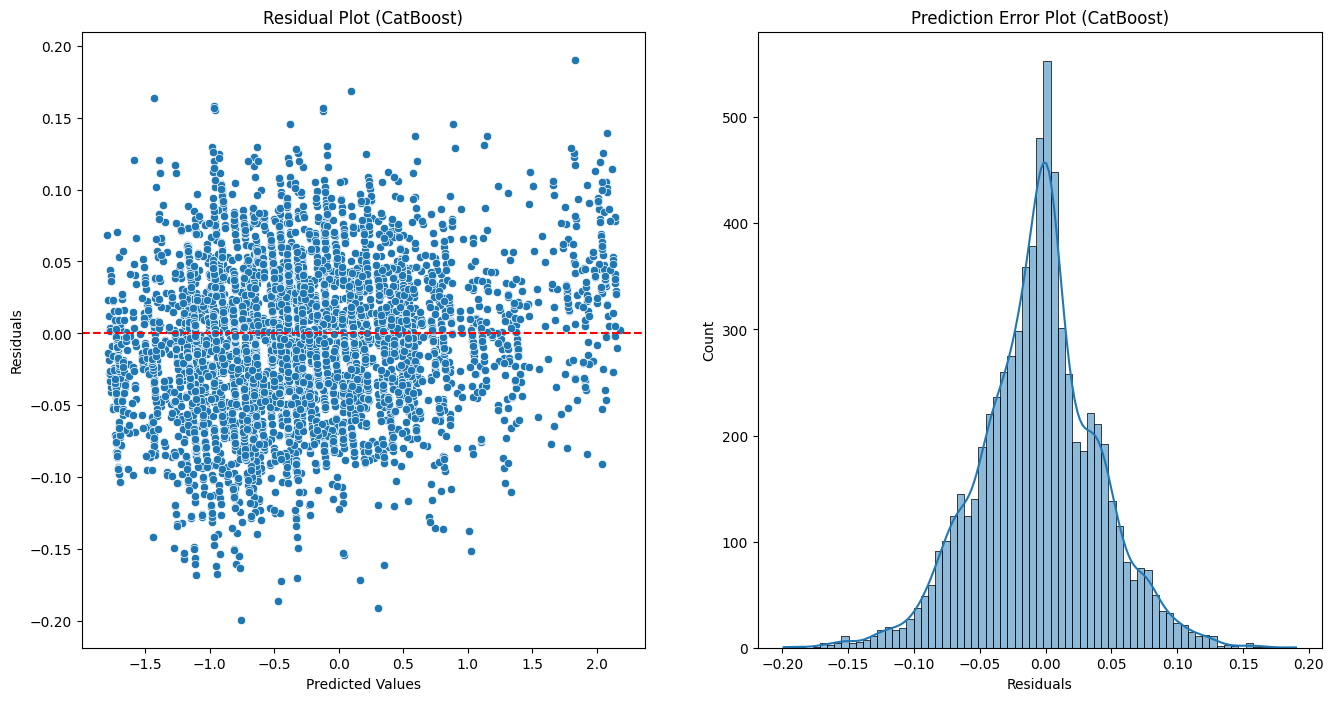

In [149]:
# import evaluation scores
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# impoert regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


models = [
    ('Linear Regression', LinearRegression()),
    ('Polynomial Regression', make_pipeline(PolynomialFeatures(2), LinearRegression())),
    ('Ridge Regression', Ridge(alpha=0.01)),
    ('Lasso', Lasso(alpha=0.01)),
    ('Decision Tree', DecisionTreeRegressor(random_state=42)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42)),
    ('AdaBoost', AdaBoostRegressor(random_state=42)),
    ('XGBoost', XGBRegressor(random_state=42)),
    ('LightGBM', LGBMRegressor(random_state=42, verbose=0)),
    ('CatBoost', CatBoostRegressor(random_state=42, verbose=0)),    
]

scores = []
# Train loop
# Trains and evaluates the model
for name, model in models:
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    mse = mean_squared_error(y_test, predictions)
    mse_print = f"{mse:.3f}"
    mae = mean_absolute_error(y_test, predictions)
    mae_print = f"{mae:.3f}"
    r2 = r2_score(y_test, predictions)
    r2_print = f"{r2:.3f}"
    lst = [mse_print,mae_print,r2_print]
    scores.append(lst)
    print(f'{name} - MSE: {mse_print}, MAE: {mae_print}, R^2: {r2_print}')
    
    # visualize the findings
    draw_results(y_test ,predictions, name)
    
    #visualize important features
    if name in ['Linear Regression', 'LightGBM']:
        plot_feature_importance(0.05, model, name, normalized_df.drop(["event_timestamp", "TARGET", ], axis= 1))

In [150]:
# let's show the results in a dataframe to compare the models' performances
columns = []
for name, model in models:
    columns.append(name)
    
scores_df = pd.DataFrame(np.array(scores).T, columns=columns).T
score_names = ["MSE", "MAE", "R^2"]
scores_df = scores_df.set_axis(score_names, axis=1)
scores_df = scores_df.sort_values(by='R^2', ascending=False)
scores_df

MSE    MAE    R^2
Linear Regression      0.002  0.029  0.997
Ridge Regression       0.002  0.029  0.997
Lasso                  0.002  0.031  0.997
Gradient Boosting      0.002  0.031  0.997
LightGBM               0.002  0.031  0.997
Polynomial Regression  0.002  0.033  0.996
XGBoost                0.002  0.035  0.996
CatBoost               0.002  0.034  0.996
AdaBoost               0.003  0.045  0.994
Decision Tree          0.004  0.049  0.992

### Without TEMP_0912

We created our target variable by shifting TEMP_0912. Which means that TEMP_0912 contains the past values of our target variable. Let's check how our models perform in the absence of such information. we can use the dataset that doesn't contain the column in question.

let's repeat the same process

In [63]:
# update the global variables again
all_cors = w_out_912.drop(["event_timestamp"], axis = 1).corr().abs()
cors = dict(all_cors["TARGET"])
cors_keys = list(cors.keys()) 

remove_highly_corr(0.9, w_out_912)
print(f"{col_count_1-1 - len(w_out_912.columns)} out of {col_count_1-1} features gets eliminated")

71 out of 118 features gets eliminated


In [64]:
split_index = 4*len(w_out_912)//5
train_data = w_out_912.loc[:split_index]
test_data = w_out_912.loc[split_index+1:]

X_train = (np.array(train_data.drop(["TARGET", "event_timestamp"], axis = 1))).astype('float64')
y_train = (np.array(train_data["TARGET"]).astype('float64')).astype('float64')
X_test = (np.array(test_data.drop(["TARGET", "event_timestamp"], axis = 1))).astype('float64')
y_test = (np.array(test_data["TARGET"])).astype('float64')

Linear Regression - MSE: 0.319, MAE: 0.461, R^2: 0.860


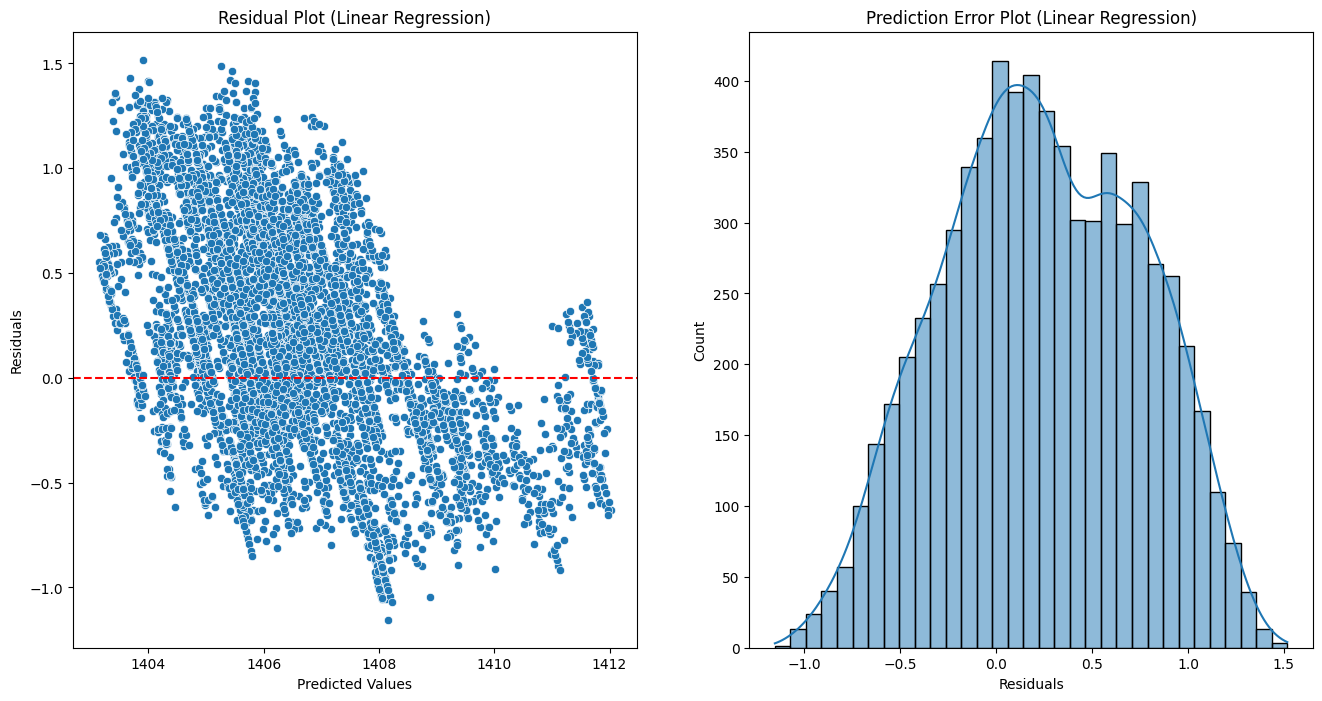

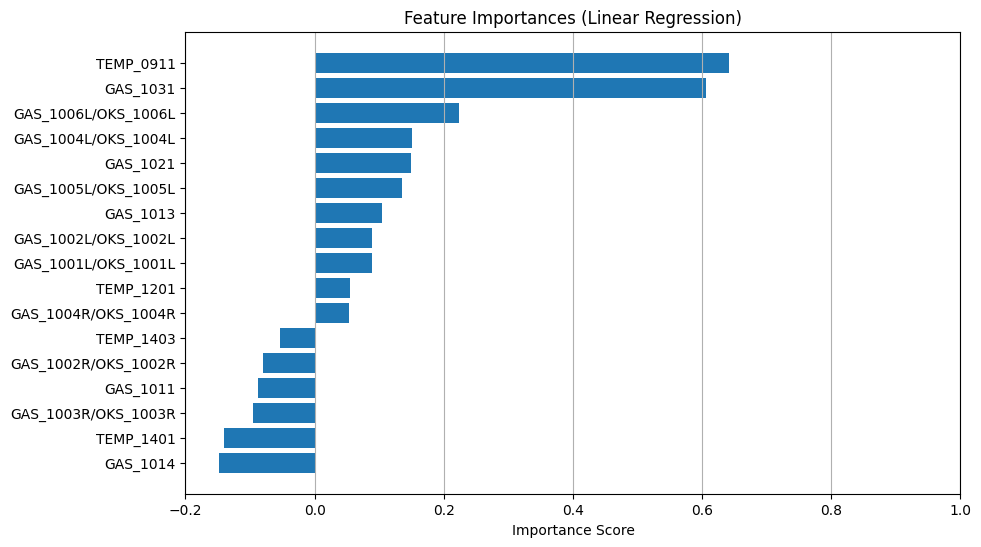

Polynomial Regression - MSE: 0.384, MAE: 0.482, R^2: 0.831


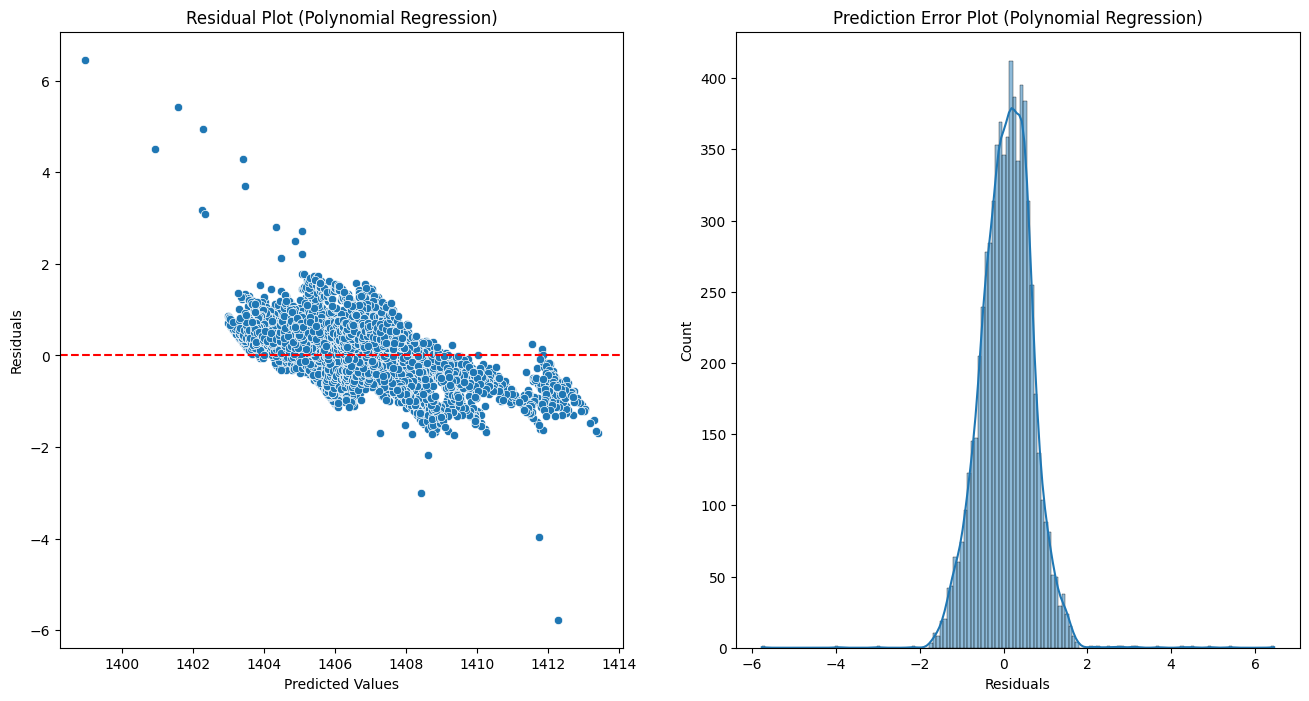

Ridge Regression - MSE: 0.319, MAE: 0.461, R^2: 0.860


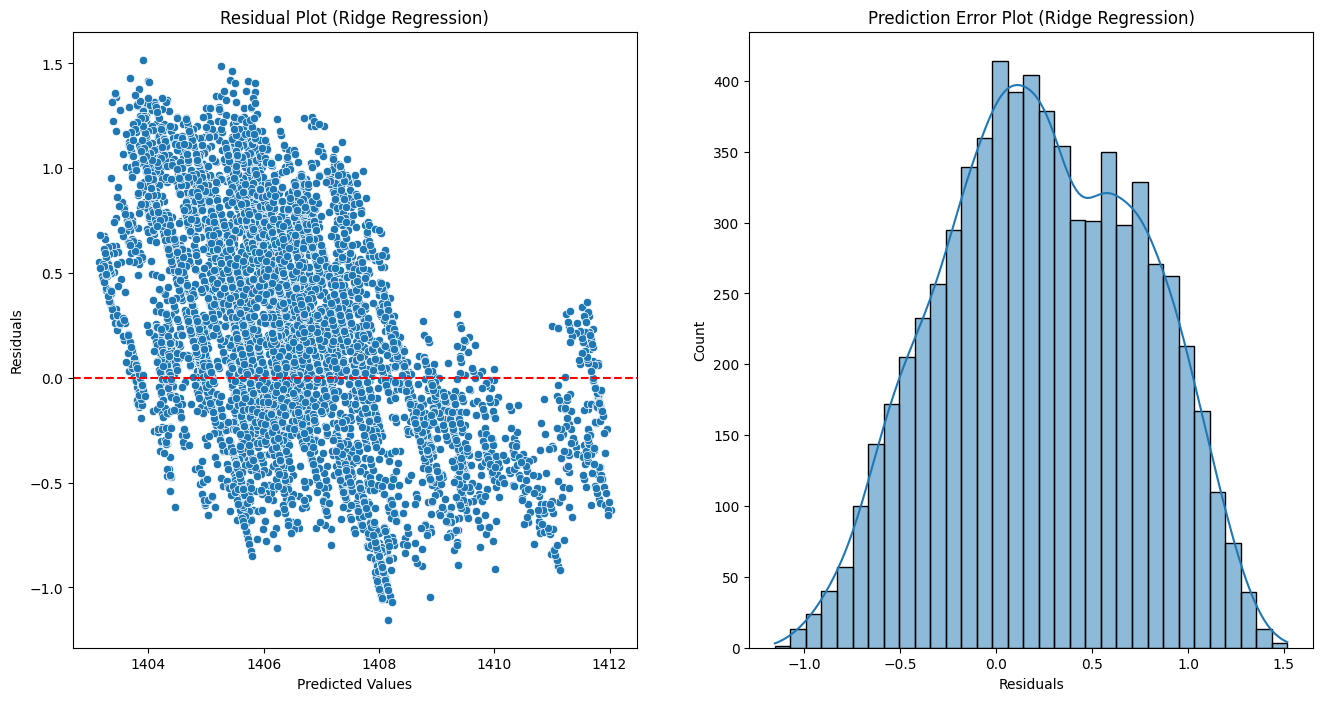

Lasso - MSE: 0.296, MAE: 0.443, R^2: 0.870


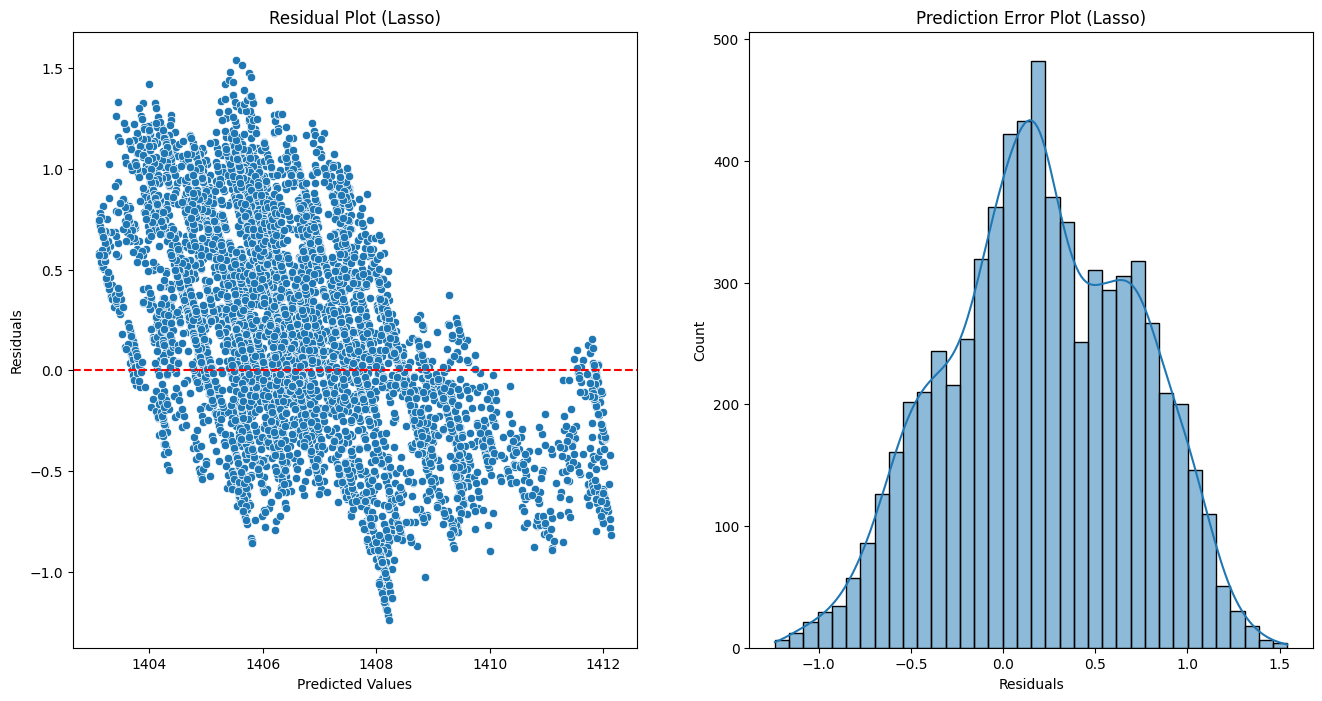

Decision Tree - MSE: 0.331, MAE: 0.453, R^2: 0.854


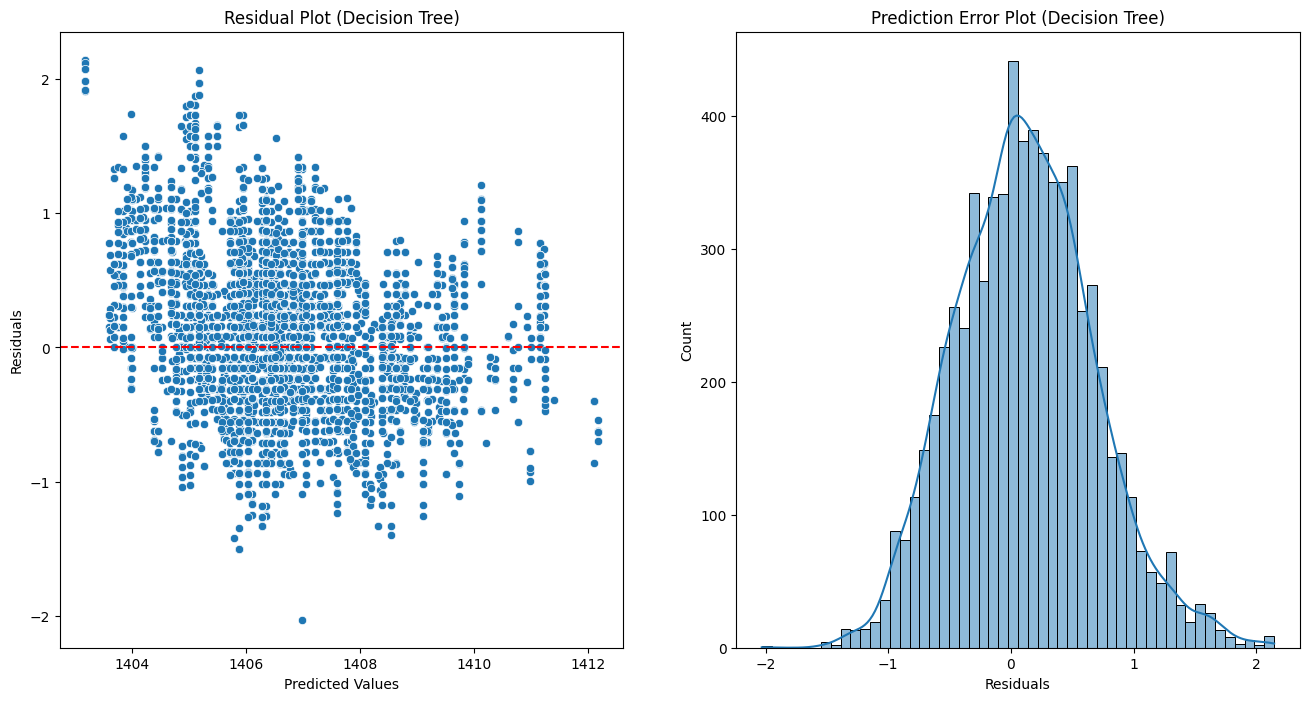

Gradient Boosting - MSE: 0.183, MAE: 0.341, R^2: 0.919


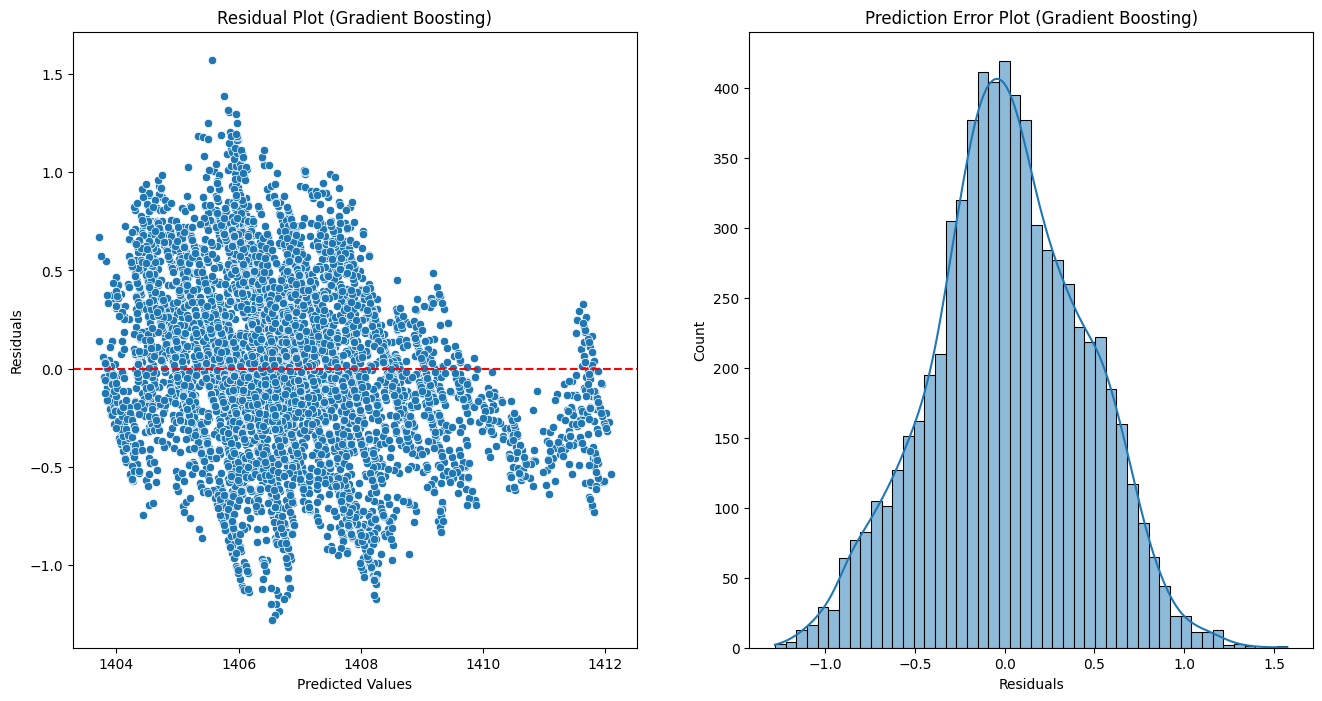

AdaBoost - MSE: 0.253, MAE: 0.407, R^2: 0.889


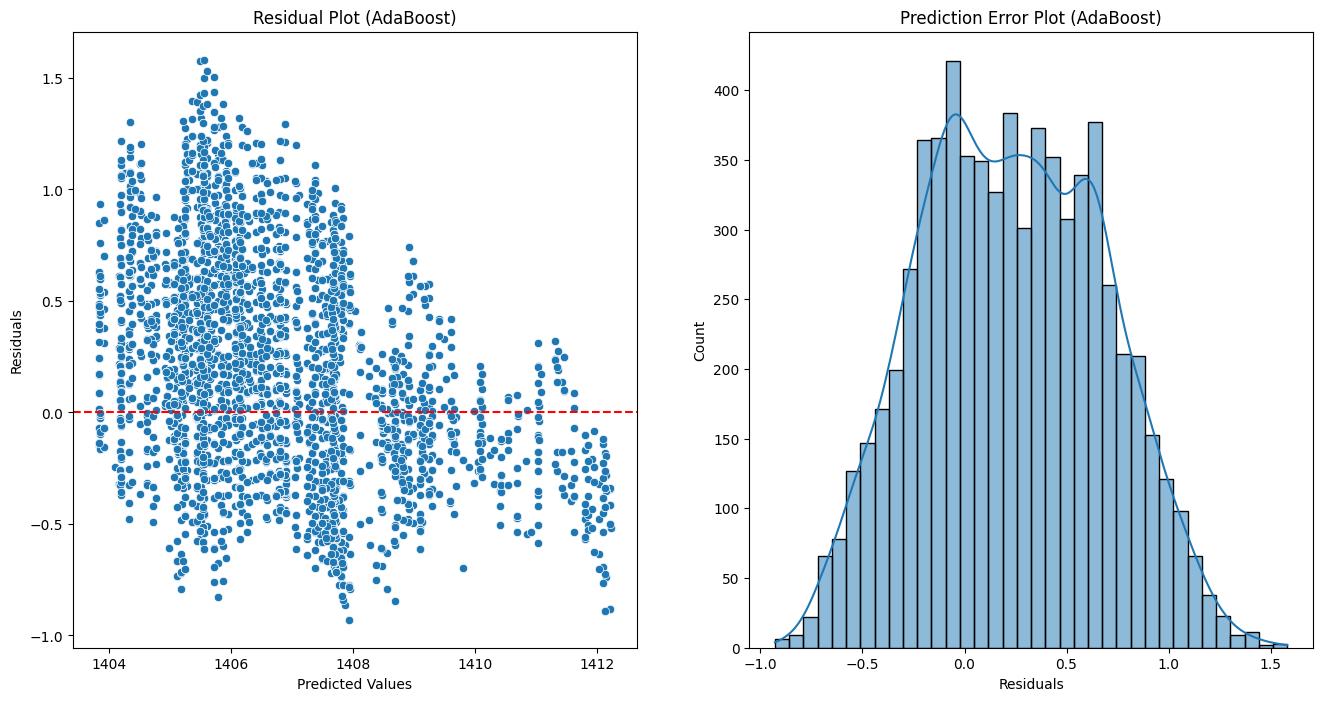

XGBoost - MSE: 0.210, MAE: 0.357, R^2: 0.908


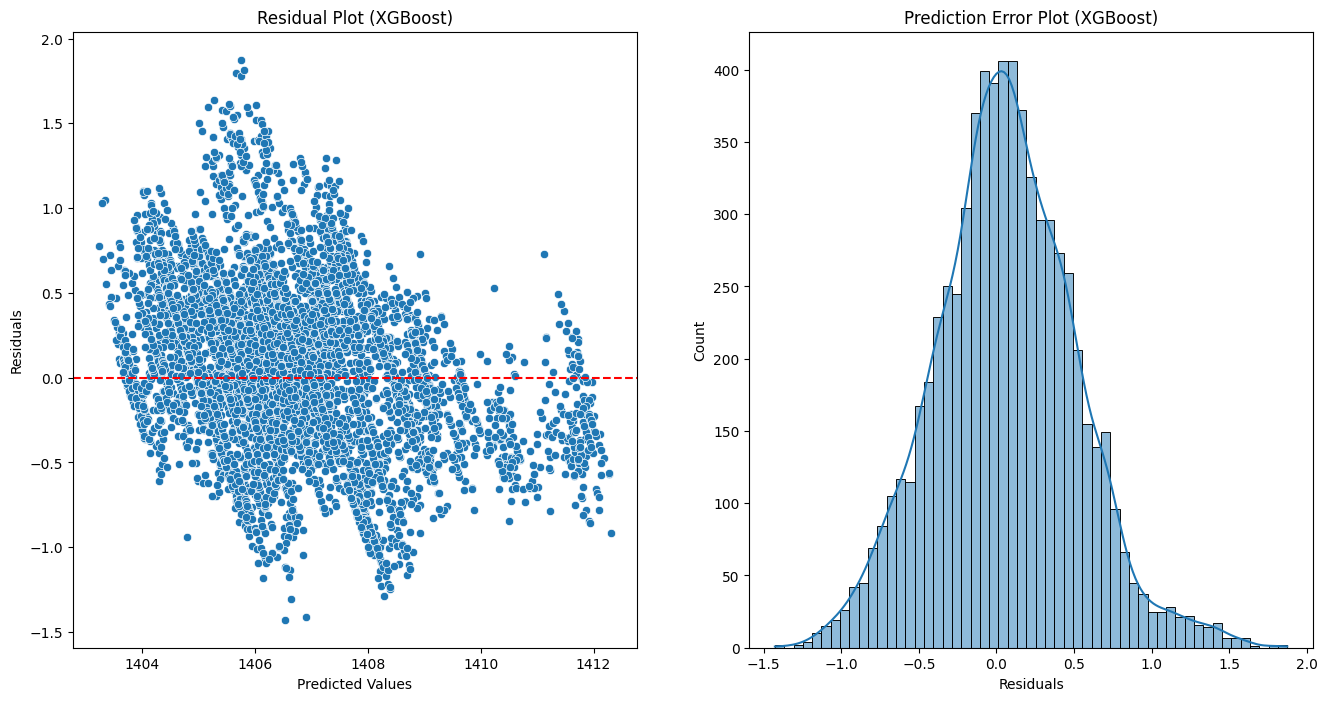

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008974 seconds.
You can set `force_col_wise=true` to remove the overhead.
LightGBM - MSE: 0.197, MAE: 0.350, R^2: 0.913


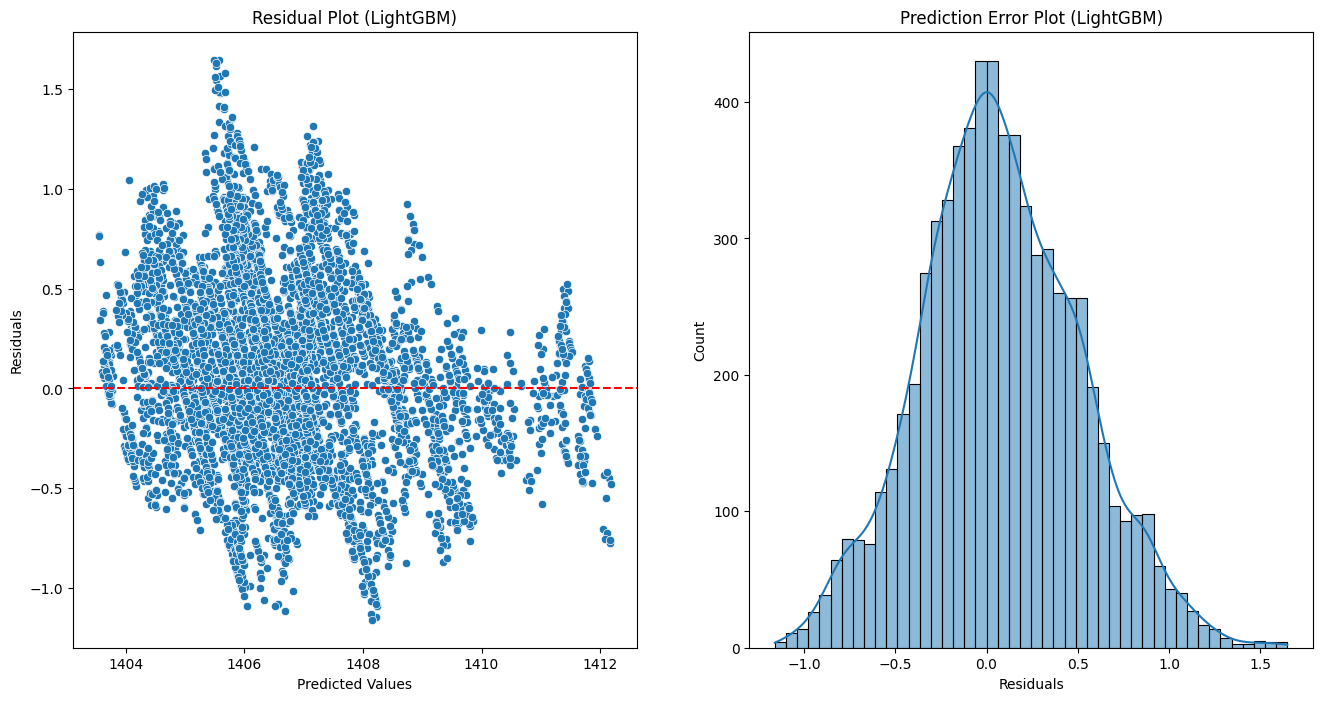

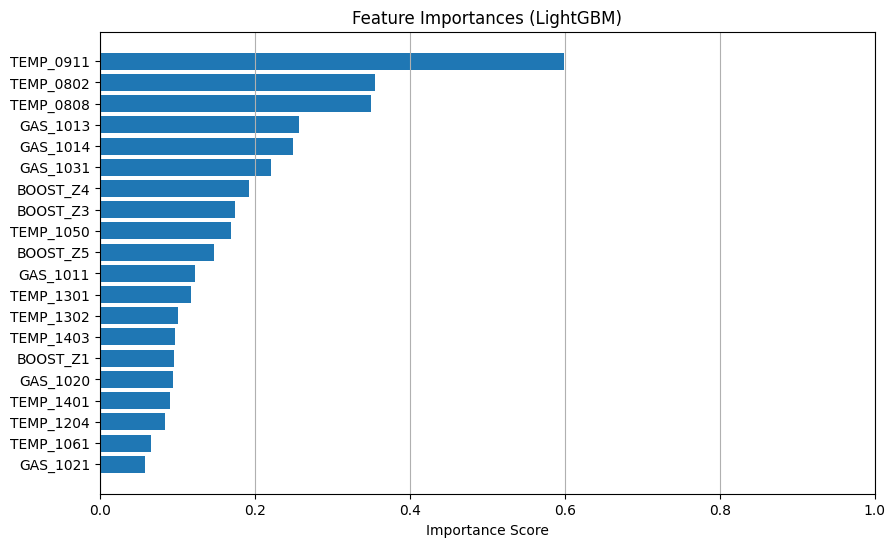

CatBoost - MSE: 0.202, MAE: 0.357, R^2: 0.911


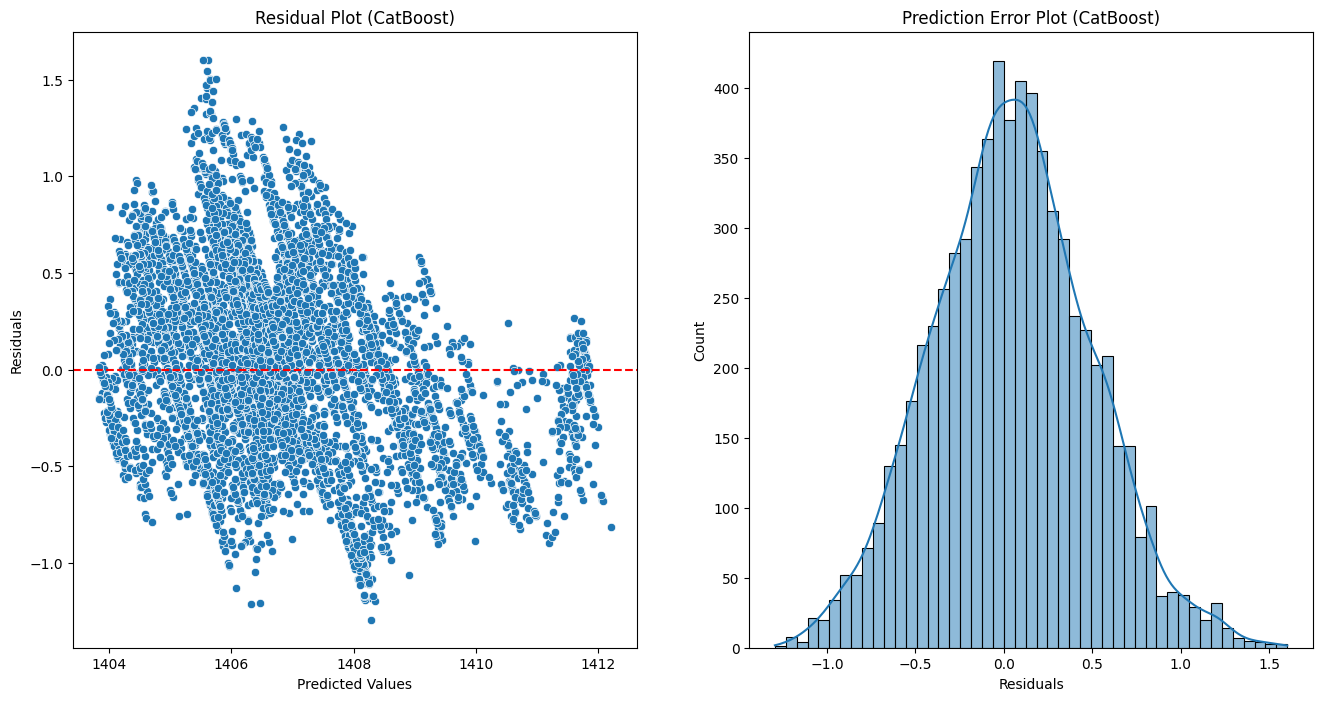

In [65]:
scores = []
for name, model in models:
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    mse = mean_squared_error(y_test, predictions)
    mse_print = f"{mse:.3f}"
    mae = mean_absolute_error(y_test, predictions)
    mae_print = f"{mae:.3f}"
    r2 = r2_score(y_test, predictions)
    r2_print = f"{r2:.3f}"
    lst = [mse_print,mae_print,r2_print]
    scores.append(lst)
    print(f'{name} - MSE: {mse_print}, MAE: {mae_print}, R^2: {r2_print}')
    
    # visualize the findings
    draw_results(y_test ,predictions, name)
    
    #plot important features
    if name in ['Linear Regression', 'LightGBM']:
        plot_feature_importance(0.05, model, name, w_out_912.drop(["event_timestamp", "TARGET", ], axis= 1))

In [66]:
scores_df = pd.DataFrame(np.array(scores).T, columns=columns).T
score_names = ["MSE", "MAE", "R^2"]
scores_df = scores_df.set_axis(score_names, axis=1)
scores_df = scores_df.sort_values(by='R^2', ascending=False)
scores_df

MSE    MAE    R^2
Gradient Boosting      0.183  0.341  0.919
LightGBM               0.197  0.350  0.913
CatBoost               0.202  0.357  0.911
XGBoost                0.210  0.357  0.908
AdaBoost               0.253  0.407  0.889
Lasso                  0.296  0.443  0.870
Linear Regression      0.319  0.461  0.860
Ridge Regression       0.319  0.461  0.860
Decision Tree          0.331  0.453  0.854
Polynomial Regression  0.384  0.482  0.831

### Hyperparameter Optimization

In [79]:
def optimize_parameter(model_algo, model_name, X_train, y_train, X_test, param_name, grid):
    r2_scores = []
    for val in grid:
        if param_name == "learning_rate":
            model = model_algo(random_state=42, learning_rate = val)
        elif param_name == "n_estimators":
            model = GradientBoostingRegressor(random_state=42, n_estimators = val)
        elif param_name == "max_depth":
            model = GradientBoostingRegressor(random_state=42, max_depth = val)
        else:
            return r2_scores
        
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        r2 = r2_score(y_test, predictions)
        r2_print = f"{r2:.3f}"
        r2_scores.append(r2)
        print(f'{model_name} ({param_name}={val}) - R^2 score: {r2_print}')
        
    return r2_scores

In [91]:
lr_grid = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
learning_rate_scores = optimize_parameter(GradientBoostingRegressor, "GradientBoosting", 
                                          X_train, y_train, X_test, "learning_rate", lr_grid)

GradientBoosting (learning_rate=0.01) - R^2 score: 0.832
GradientBoosting (learning_rate=0.05) - R^2 score: 0.915
GradientBoosting (learning_rate=0.1) - R^2 score: 0.919
GradientBoosting (learning_rate=0.2) - R^2 score: 0.904
GradientBoosting (learning_rate=0.5) - R^2 score: 0.894
GradientBoosting (learning_rate=1.0) - R^2 score: 0.835


In [86]:
n_est_grid = [10, 20, 30, 40, 50, 200, 500]
n_est_scores = optimize_parameter(GradientBoostingRegressor, "GradientBoosting", 
                                          X_train, y_train, X_test, "n_estimators", n_est_grid)

GradientBoosting (n_estimators=10) - R^2 score: 0.846
GradientBoosting (n_estimators=20) - R^2 score: 0.922
GradientBoosting (n_estimators=30) - R^2 score: 0.916
GradientBoosting (n_estimators=40) - R^2 score: 0.917
GradientBoosting (n_estimators=50) - R^2 score: 0.920
GradientBoosting (n_estimators=200) - R^2 score: 0.906
GradientBoosting (n_estimators=500) - R^2 score: 0.907


In [92]:
max_depth_grid = [5, 10, None]
max_depth_scores = optimize_parameter(GradientBoostingRegressor, "GradientBoosting", 
                                          X_train, y_train, X_test, "max_depth", max_depth_grid)

GradientBoosting (max_depth=5) - R^2 score: 0.917
GradientBoosting (max_depth=10) - R^2 score: 0.894
GradientBoosting (max_depth=None) - R^2 score: 0.852


In [151]:
def visualize_param_opt(x, y, parameter_name):
    if parameter_name == "learning_rate":
        
        
        
    x.append('default')
    y.append(0.919)
    
    # Format values to 3 decimal places
    y = [round(val, 3) for val in y]
    
    # Convert all x values to strings
    x = [str(val) for val in x]
    
    # Create a dictionary
    data = {x[i]: y[i] for i in range(len(x))}
    
    # Sort dictionary by values descendingly
    sorted_data = dict(sorted(data.items(), key=lambda item: item[1], reverse=True))
    
    
    # Visualize with bar plot
    plt.bar(sorted_data.keys(), sorted_data.values())
    plt.ylabel('R^2 Scores')
    plt.title(f'Optimizing {parameter_name}')
    plt.xticks(rotation=45)  # Rotate x-labels for better visibility
    plt.ylim(np.min(y)-np.std(y), np.max(y)+np.std(y))  # Set y-axis limits
    plt.tight_layout()
    plt.grid(axis='y')
    plt.show()

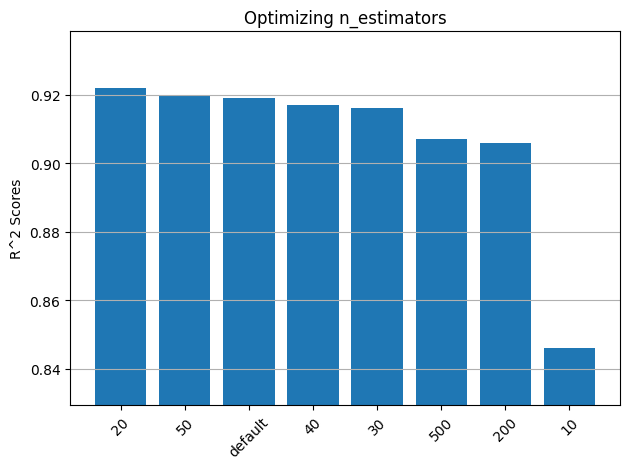

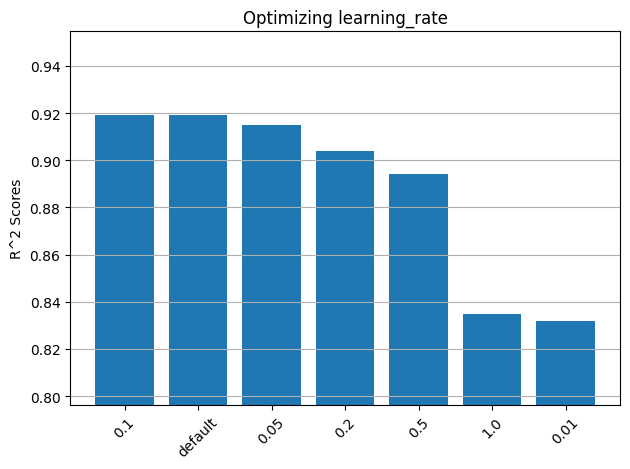

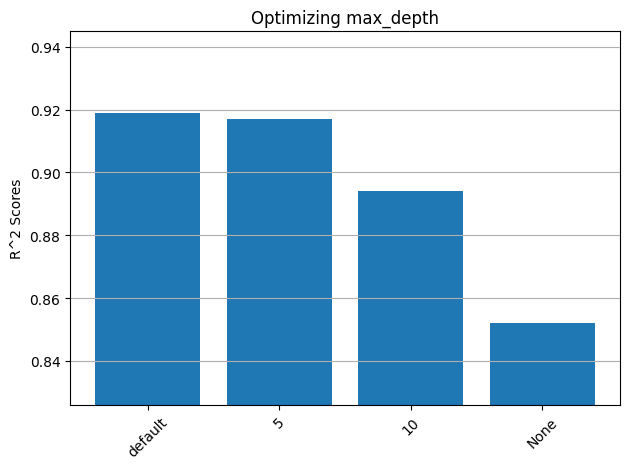

In [152]:
visualize_param_opt(n_est_grid,n_est_scores,"n_estimators")
visualize_param_opt(lr_grid,learning_rate_scores,"learning_rate")
visualize_param_opt(max_depth_grid,max_depth_scores,"max_depth")